
*Last update: August 2023*  
*Contact:* fdrs@ifrc.org or simon.weiss@ifrc.org  
*FDRS focal point:* Simon Weiss, FDRS Data Analyst


# How to deal with Missing Values? FDRS imputation methodology in python
-----------


The FDRS is ambitious and wide reaching. Although the data quality and reporting are improving each year, data is missing for some National Societies. As a result, some data fluctuations may be misleading: trend lines can drop for a given year when there is missing data, and some National Societies are excluded from the total and then appear again in another year.In order to better represent the network and better count everyone, FDRS implement every year data imputation techniques. 

The purpose of this notebook is to apply the method selected by the FDRS team and to interact with the FDRS backoffice with a post method to publish the imputed values. 
The ingested data is  replicated and displayed on the website https://data.ifrc.org/FDRS/ and used in FDRS research such as [Everyone count report](https://data-api.ifrc.org/documents/noiso/Everyone%20Counts%20Report%202022%20EN.pdf). 

Therefore this is not a research notebook but a production notebook. It aims to simply expose the FDRS methodology of imputation step by step. A related python script has been created: [imputing.py]() which allows to launch this methodology once. 

The approach chosen was to replace the 2019, 2020 and 2021 missing data as well as to apply two different techniques according to the indicator categories, in the previous years all NSs reported their data then no input technique was employed.   

The imputing applies only to main indicators and does not apply to disaggregated levels to maintain consistency across years. A detailed description of the methodology is available in the pdf [Missing Data]()


## Table of Contents


1. [Import Necessary Packages](#import-packages)
2. [Selecting Production and Staging Environment](#environment-selection)
3. [Data Retrieval](#data-retrieval)
4. [Data Imputation](#data-imputation)
5. [POST Method to Update Back-end](#post-method)

 

## 1. Imports and Initial Configurations

We'll start by loading the necessary Python modules and libraries for our analysis.


In [9]:
import os
import sys
import time
import warnings
from datetime import datetime
import pandas as pd
import numpy as np
import requests
from pandas import json_normalize
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import math

warnings.filterwarnings('ignore')

## 2. Configuration Loading

Before proceeding, let's select the desired environment. This will determine the configuration settings we'll use throughout the notebook.


In [10]:
def select_environment(config_prod_path, config_staging_path):
    """Select the environment and load the respective configuration."""
    env = ''
    #ask the user whether they want to select staging or prod
    while env not in ['staging', 'prod']:
        env = input("Select environment ('staging' or 'prod'): ").lower()
        #if they select prod
        if env == 'prod':
            confirm = input("WARNING: You've selected the PRODUCTION environment. Are you sure? (yes/no) ")
            #confirm, else staging
            if confirm.lower() != 'yes':
                print("Switching to 'staging' by default for safety.")
                env = 'staging'
    #open and load the config file            
    try:
        with open(config_prod_path if env == 'prod' else config_staging_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        raise Exception(f"Configuration file for {env} not found.")

Configuration

In [11]:
config_prod_path = '../src/config/config_prod.json'
config_staging_path = '../src/config/config_staging.json'
#open and load the config file
config = select_environment(config_prod_path, config_staging_path)
print(f"Loaded configuration for {config['ENV']} environment.")
user_email = input('Please provide your FDRS data analyst email: ')

Loaded configuration for staging environment.


## 3. Data Retrieval


### 3.1 Import necessary modules for data retrieval

In [12]:
#This is for adding src and data to the path, to load config and secondary code, fdrsapi
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, "src", "data"))
from fdrsapi import api_function, baseline, api_function_imputed


In [13]:
#Generate fdrs codebook and store it in references folder

base_url = config['BASE_URL']
KPI = json_normalize(data=requests.get(f"{base_url}indicator?apiKey={config['API_KEY_PUBLIC']}").json())
codebook_path = os.path.join('..', 'references', 'codebook.xlsx')
KPI.to_excel(codebook_path)
codebook = pd.read_excel(codebook_path)

In [14]:
#From the codebook, we get all the indicators we need

codebook = pd.read_excel(r"..\references\codebook.xlsx")
#We scan for NS Reach - CPD to find the relevant total KPIs for reach, and we ad Train and DonBlood
kpi_reach = codebook.query('KPI_Note == "NS Reach - CPD"')["KPI_Code"].to_list() + ["KPI_TrainFA_Tot", "KPI_DonBlood_Tot"]
#metadata kpis are like submitted, validated
metadata_kpis = codebook.query('KPI_Note == "Metadata"')["KPI_Code"].tolist()
#gov KPIs
kpi_gov_code = ["KPI_GB_Tot", "KPI_PeopleVol_Tot", "KPI_PStaff_Tot", "KPI_noLocalUnits"]
#finance KPIs
kpi_fi_code = ["KPI_IncomeLC_CHF", "KPI_expenditureLC_CHF"]

exclude_kpis = ["KPI_Year", "DON_Code", "KPI_Id"]
metadata_kpis = [kpi for kpi in metadata_kpis if kpi not in exclude_kpis]
kpi_code = kpi_reach + kpi_gov_code + kpi_fi_code + metadata_kpis


In [15]:
#counting nb of considered KPIs
print("number of total KPI considered:", len(kpi_code)-2)

number of total KPI considered: 48


### 3.2 Get data from FDRS API

In [16]:
#select relevant years (should only be 4 consecutive years, or imputing will not tke the right average)
years = ["2019", "2020", "2021", "2022"]
#gets published data from the entities (basic info) and KpiValue (KPIs and their values) endpoint
time_series = api_function(years, kpi_code, config)
original_data = time_series.copy()
original_data

,KPI_DON_code,NSO_DON_name,NSO_ZON_name,iso_3,KPI_Year,KPI ID,KPI_ClimateHeat_CPD,KPI_Climate_CPD,KPI_DonBlood_Tot,KPI_FirstSubmitDate,...,KPI_ReachM_CPD,KPI_ReachRCRCEd_CPD,KPI_ReachSI_CPD,KPI_ReachS_CPD,KPI_ReachWASH_CPD,KPI_TrainFA_Tot,KPI_WasSubmitted,KPI_expenditureLC_CHF,KPI_noLocalUnits,validated
0,DAF001,Afghan Red Crescent,Asia Pacific,AFG,2019.0,DAF0012019.0,NaN,NaN,519.0,2021-01-04T07:21:28.53,...,NaN,NaN,NaN,NaN,NaN,760.0,1.0,1.525219e+07,122.0,1.0
1,DAL001,Albanian Red Cross,Europe and Central Asia,ALB,2019.0,DAL0012019.0,NaN,NaN,5726.0,2021-01-07T15:04:51.567,...,500.0,NaN,17350.0,7000.0,30000.0,64000.0,1.0,1.316851e+06,39.0,1.0
2,DDZ001,Algerian Red Crescent,Middle East and North Africa,DZA,2019.0,DDZ0012019.0,NaN,NaN,NaN,2021-01-15T18:28:27.973,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,36.0,1.0
3,DUS001,American Red Cross,Americas,USA,2019.0,DUS0012019.0,NaN,NaN,2548842.0,2020-10-14T22:39:18.453,...,NaN,NaN,NaN,NaN,NaN,2625573.0,1.0,2.920267e+09,263.0,1.0
4,DAD001,Andorran Red Cross,Europe and Central Asia,AND,2019.0,DAD0012019.0,NaN,NaN,NaN,2020-07-29T11:28:43.85,...,NaN,NaN,100.0,NaN,NaN,2964.0,1.0,1.257637e+06,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,DVE001,Venezuelan Red Cross,Americas,VEN,2022.0,DVE0012022.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,DVN001,Vietnam Red Cross Society,Asia Pacific,VNM,2022.0,DVN0012022.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,DYE001,Yemen Red Crescent Society,Middle East and North Africa,YEM,2022.0,DYE0012022.0,NaN,913.0,NaN,2023-04-30T22:14:13.27,...,762890.0,10500.0,4871.0,333508.0,1202413.0,597.0,1.0,3.758236e+06,32.0,1.0
766,DZM001,Zambia Red Cross Society,Africa,ZMB,2022.0,DZM0012022.0,0.0,1047.0,0.0,2023-08-29T11:30:48.44,...,5130.0,0.0,NaN,4776.0,179700.0,2352.0,1.0,NaN,2.0,0.0


### 3.3 Analyzing FDRS data

In [17]:
# Initialize a DataFrame to store the counts -> meta data analysis
metadata_counts = pd.DataFrame()

# Loop over each metadata KPI
for kpi in metadata_kpis:
    if "Date" in kpi:  # Check if the KPI is a date indicator
        yes_count = time_series[time_series[kpi].notna()].groupby('KPI_Year').size()
    else:
        yes_count = time_series[time_series[kpi] == 1.0].groupby('KPI_Year').size()

    no_count = time_series[time_series[kpi] == 0.0].groupby('KPI_Year').size()
    na_count = time_series[time_series[kpi].isna()].groupby('KPI_Year').size()
    
    # Construct a temporary DataFrame and append it to the main DataFrame
    temp_df = pd.DataFrame({
        'KPI': kpi,
        'True': yes_count,
        'False': no_count,
        'NA': na_count
    }).reset_index()
    
    metadata_counts = metadata_counts._append(temp_df, ignore_index=True)

# Pivot the dataframe for a better view
pivot_metadata_counts = metadata_counts.pivot(index='KPI', columns='KPI_Year')

# Display the metadata counts table
# Specify the order of KPIs to display at the top
priority_kpis = ['KPI_WasSubmitted', 'validated']

# Reorder the index to have priority KPIs at the top
pivot_metadata_counts = pivot_metadata_counts.reindex(priority_kpis + [kpi for kpi in pivot_metadata_counts.index if kpi not in priority_kpis])

# Display the pivoted table for comparison
pivot_metadata_counts


True                       False                \
KPI_Year                2019.0 2020.0 2021.0 2022.0 2019.0 2020.0 2021.0   
KPI                                                                        
KPI_WasSubmitted         167.0  177.0  175.0  129.0    NaN    NaN    1.0   
validated                158.0  166.0  162.0  102.0    9.0   11.0   13.0   
KPI_FirstSubmitDate      167.0  177.0  176.0  130.0    NaN    NaN    NaN   
KPI_NSFP_PublishDate     164.0  172.0    NaN    NaN    NaN    NaN    NaN   
KPI_NSFP_StartDate       167.0  171.0  175.0  126.0    NaN    NaN    NaN   
KPI_NSFP_SubmitDate      162.0  172.0  174.0  107.0    NaN    NaN    NaN   
KPI_NSFP_ValidationDate  164.0  132.0  171.0   94.0    NaN    NaN    NaN   
KPI_NSFP_WasPublished    164.0  172.0    NaN    NaN    NaN    NaN    NaN   
KPI_NSFP_WasStarted      167.0  171.0  175.0  126.0    NaN    NaN    NaN   
KPI_NSFP_WasSubmitted    162.0  172.0  174.0  107.0    NaN    NaN    NaN   
KPI_NSFP_WasValidated    164.0  132.0  171.0   94.0    NaN    NaN    NaN   
KPI_NSGS_PublishDate     167.0  177.0    NaN    NaN    NaN    NaN    NaN   
KPI_NSGS_StartDate       167.0  178.0  180.0  142.0    NaN    NaN    NaN   
KPI_NSGS_SubmitDate      167.0  175.0  173.0  128.0    NaN    NaN    NaN   
KPI_NSGS_ValidationDate  164.0  128.0  169.0   95.0    NaN    NaN    NaN   
KPI_NSGS_WasPublished    167.0  177.0    NaN    NaN    NaN    NaN    NaN   
KPI_NSGS_WasStarted      167.0  178.0  180.0  142.0    NaN    NaN    NaN   
KPI_NSGS_WasSubmitted    167.0  175.0  173.0  128.0    NaN    NaN    NaN   
KPI_NSGS_WasValidated    164.0  128.0  169.0   95.0    NaN    NaN    NaN   
KPI_NSR_PublishDate      162.0  172.0    NaN    NaN    NaN    NaN    NaN   
KPI_NSR_StartDate        167.0  177.0  179.0  134.0    NaN    NaN    NaN   
KPI_NSR_SubmitDate       165.0  174.0  174.0  123.0    NaN    NaN    NaN   
KPI_NSR_ValidationDate   161.0  120.0  171.0   95.0    NaN    NaN    NaN   
KPI_NSR_WasPublished     162.0  172.0    NaN    NaN    NaN    NaN    NaN   
KPI_NSR_WasStarted       167.0  177.0  179.0  134.0    NaN    NaN    NaN   
KPI_NSR_WasSubmitted     165.0  174.0  174.0  123.0    NaN    NaN    NaN   
KPI_NSR_WasValidated     161.0  120.0  171.0   95.0    NaN    NaN    NaN   

                                   NA                       
KPI_Year                2022.0 2019.0 2020.0 2021.0 2022.0  
KPI                                                         
KPI_WasSubmitted           1.0     25     15     16     62  
validated                 28.0     25     15     17     62  
KPI_FirstSubmitDate        NaN     25     15     16     62  
KPI_NSFP_PublishDate       NaN     28     20    192    192  
KPI_NSFP_StartDate         NaN     25     21     17     66  
KPI_NSFP_SubmitDate        NaN     30     20     18     85  
KPI_NSFP_ValidationDate    NaN     28     60     21     98  
KPI_NSFP_WasPublished      NaN     28     20    192    192  
KPI_NSFP_WasStarted        NaN     25     21     17     66  
KPI_NSFP_WasSubmitted      NaN     30     20     18     85  
KPI_NSFP_WasValidated      NaN     28     60     21     98  
KPI_NSGS_PublishDate       NaN     25     15    192    192  
KPI_NSGS_StartDate         NaN     25     14     12     50  
KPI_NSGS_SubmitDate        NaN     25     17     19     64  
KPI_NSGS_ValidationDate    NaN     28     64     23     97  
KPI_NSGS_WasPublished      NaN     25     15    192    192  
KPI_NSGS_WasStarted        NaN     25     14     12     50  
KPI_NSGS_WasSubmitted      NaN     25     17     19     64  
KPI_NSGS_WasValidated      NaN     28     64     23     97  
KPI_NSR_PublishDate        NaN     30     20    192    192  
KPI_NSR_StartDate          NaN     25     15     13     58  
KPI_NSR_SubmitDate         NaN     27     18     18     69  
KPI_NSR_ValidationDate     NaN     31     72     21     97  
KPI_NSR_WasPublished       NaN     30     20    192    192  
KPI_NSR_WasStarted         NaN     25     15     13     58  
KPI_NSR_WasSubmitted       NaN     27

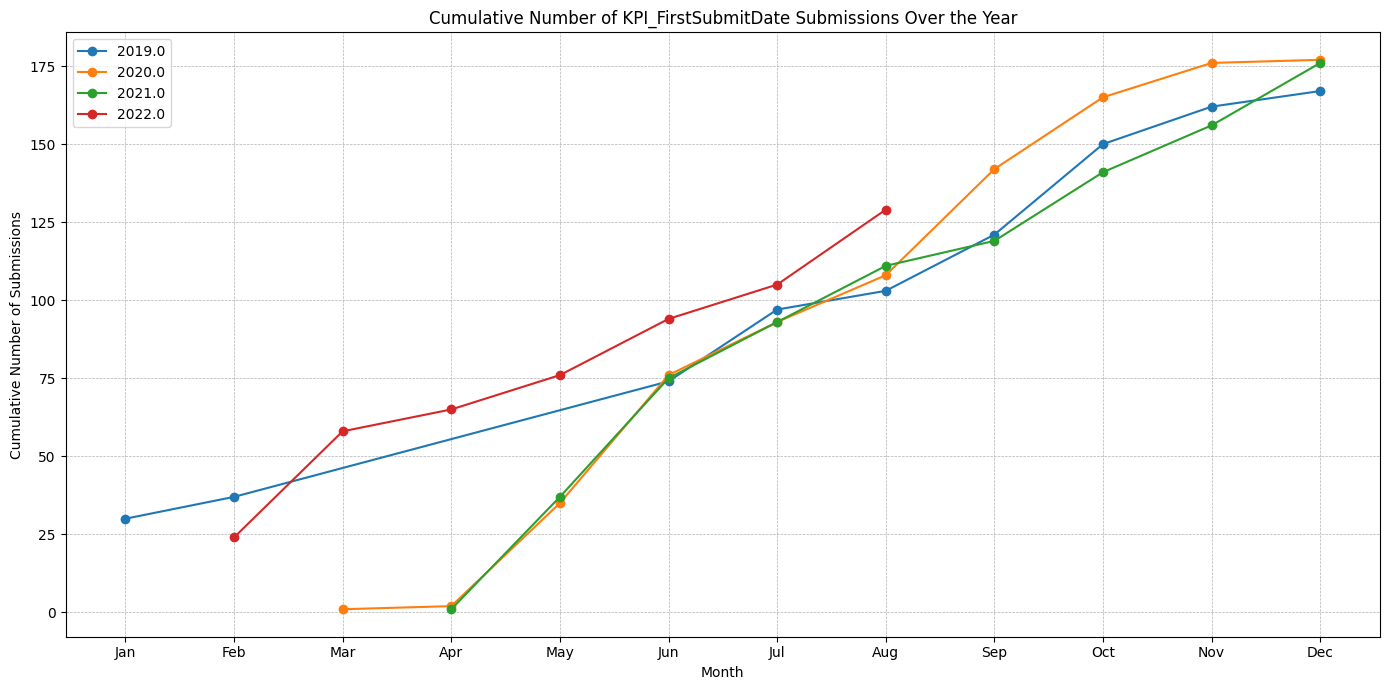

In [18]:
#Analyse when the data has been submitted
time_series['KPI_FirstSubmitDate'] = pd.to_datetime(time_series['KPI_FirstSubmitDate'], errors='coerce')

# Extract month
time_series['Month'] = time_series['KPI_FirstSubmitDate'].dt.month

# Group by year and month, then compute the cumulative count
grouped_cumulative = time_series.groupby(['KPI_Year', 'Month']).size().groupby(level=0).cumsum().reset_index(name='Cumulative Count')

# Plot
plt.figure(figsize=(14, 7))
for year in time_series['KPI_Year'].unique():
    subset = grouped_cumulative[grouped_cumulative['KPI_Year'] == year]
    plt.plot(subset['Month'], subset['Cumulative Count'], label=year, marker='o')

plt.title('Cumulative Number of KPI_FirstSubmitDate Submissions Over the Year')
plt.xlabel('Month')
plt.ylabel('Cumulative Number of Submissions')
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


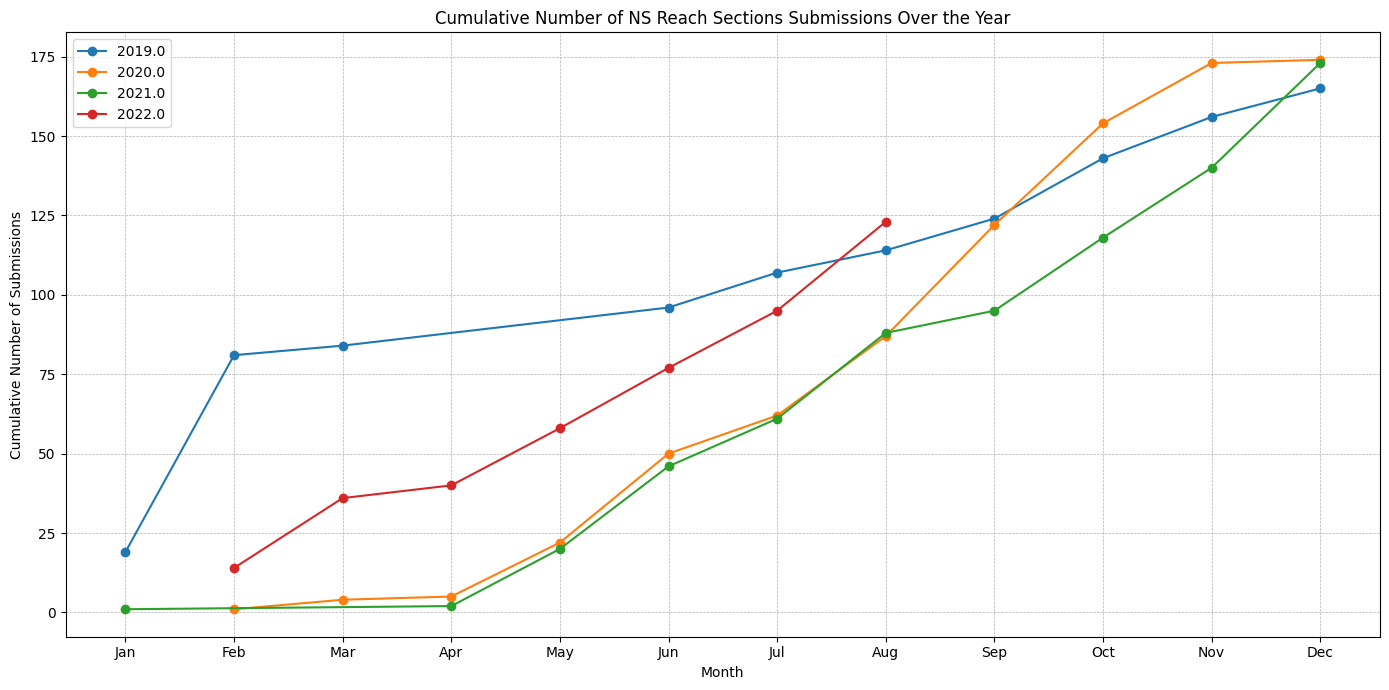

In [19]:
#Analyse when the reach data has been submitted
time_series['KPI_NSR_SubmitDate'] = pd.to_datetime(time_series['KPI_NSR_SubmitDate'], errors='coerce')


# Extract month
time_series['Month'] = time_series['KPI_NSR_SubmitDate'].dt.month

# Group by year and month, then compute the cumulative count
grouped_cumulative = time_series.groupby(['KPI_Year', 'Month']).size().groupby(level=0).cumsum().reset_index(name='Cumulative Count')

# Plot
plt.figure(figsize=(14, 7))
for year in time_series['KPI_Year'].unique():
    subset = grouped_cumulative[grouped_cumulative['KPI_Year'] == year]
    plt.plot(subset['Month'], subset['Cumulative Count'], label=year, marker='o')

plt.title('Cumulative Number of NS Reach Sections Submissions Over the Year')
plt.xlabel('Month')
plt.ylabel('Cumulative Number of Submissions')
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# 4. Data Imputation

In [20]:
def impute_data(df, kpi_reach_code, kpi_gov,kpi_fi_code, selected_year):
    """
    Impute missing data in the dataframe based on various conditions.
    
    Parameters:
        df (pd.DataFrame): The original dataframe with potential missing values.
        kpi_reach_code (list): List of KPI codes related to reach.
        kpi_gov_fi_code (list): List of KPI codes related to governance and financial indicators.
        selected_year (int): The year for which to perform the imputation.
        
    Returns:
        pd.DataFrame: Dataframe with imputed values.
    """


    data = df.copy()
    #we create a flag for which data we want to impute.
    #it has to match the selected year
    condition_selected_year = data['KPI_Year'] == float(selected_year)
    #The NS must have submitted their data (e.g. it is not just saved)
    condition_not_submitted = data['KPI_WasSubmitted'] != 1.0
    #In a special case, we look if the governance section has not been submitted
    condition_nsgs_not_submitted = data['KPI_NSGS_WasSubmitted'] != 1.0

    #for each reach KPI,
    for col in kpi_reach_code:
        #Flag when it has the relevant year, NS has not submitted, and the value is empty
        mask = condition_selected_year & condition_not_submitted & data[col].isna()
        #Group by NS, and take the mean of a block of 3 iteratively
        imputed_col = data.groupby("NSO_DON_name")[col].transform(lambda x: x.fillna(x.mean(), limit=3))
        #replace the values that we flagged
        data[col] = np.where(mask,imputed_col,data[col])

    #for each gov/fi kpi
    for col in kpi_gov_code+kpi_fi_code:
        #Flag when it has the relevant year, NS has not submitted, and the value is empty
        mask = condition_selected_year & condition_not_submitted & data[col].isna()
        #Group by NS, and take the last value of a block of 3 iteratively
        imputed_col = data.groupby("NSO_DON_name")[col].transform(lambda x: x.fillna(method='ffill', limit=3))
        #replace the values that we flagged
        data[col] = np.where(mask,imputed_col,data[col])

    #for gov kpi, we have a special condition. If the data was submitted, but the gov section was not submitted, we also impute the gov section
    condition_special = (data['KPI_WasSubmitted'] == 1.0) & condition_nsgs_not_submitted
    #for each gov kpi
    for col in kpi_gov_code:
        #Flag when it has the relevant year, NS has submitted but not gov section, and the value is empty
        mask = condition_selected_year & condition_special & data[col].isna()
        #Group by NS, and take the last value of a block of 3 iteratively
        imputed_col = data.groupby("NSO_DON_name")[col].transform(lambda x: x.fillna(method='ffill', limit=3))
        #replace the values that we flagged
        data[col] = np.where(mask,imputed_col,data[col])

    return data

In [21]:
# Perform imputation for the year 2022
imputed_data_2022 = impute_data(time_series, kpi_reach, kpi_gov_code,kpi_fi_code, 2022)

### Imputing Analysis

In [22]:
#Do some checks with previous years and imputation aggregations

imputed_data_2021 = impute_data(time_series, kpi_reach, kpi_gov_code,kpi_fi_code, 2021)
imputed_data_2022 = impute_data(time_series, kpi_reach, kpi_gov_code,kpi_fi_code, 2022)

# Compare imputed and original (non-imputed) data
print("\nComparison (Original vs. Imputed) for 2022:")
print("Original:", time_series[time_series["KPI_Year"] == 2022][["NSO_DON_name", "KPI_PeopleVol_Tot"]].sum())
print("Imputed:", imputed_data_2022[imputed_data_2022["KPI_Year"] == 2022][["NSO_DON_name", "KPI_PeopleVol_Tot"]].sum())

print("\nComparison (Original vs. Imputed) for 2021:")
print("Original:", time_series[time_series["KPI_Year"] == 2021][["NSO_DON_name", "KPI_PeopleVol_Tot"]].sum())
print("Imputed:", imputed_data_2021[imputed_data_2021["KPI_Year"] == 2021][["NSO_DON_name", "KPI_PeopleVol_Tot"]].sum())

# Compare imputed and original (non-imputed) data
print("\nComparison (Original vs. Imputed) for 2022:")
print("Original:", time_series[time_series["KPI_Year"] == 2022][["NSO_DON_name", "KPI_IncomeLC_CHF"]].sum())
print("Imputed:", imputed_data_2022[imputed_data_2022["KPI_Year"] == 2022][["NSO_DON_name", "KPI_IncomeLC_CHF"]].sum())

print("\nComparison (Original vs. Imputed) for 2021:")
print("Original:", time_series[time_series["KPI_Year"] == 2021][["NSO_DON_name", "KPI_IncomeLC_CHF"]].sum())
print("Imputed:", imputed_data_2021[imputed_data_2021["KPI_Year"] == 2021][["NSO_DON_name", "KPI_IncomeLC_CHF"]].sum())


# Compare imputed and original (non-imputed) data for KPI_ReachDRER_CPD_IP
print("\nComparison (Original vs. Imputed) for KPI_ReachDRER_CPD in 2022:")
print("Original:", time_series[time_series["KPI_Year"] == 2022][["NSO_DON_name", "KPI_ReachDRER_CPD"]].sum())
print("Imputed:", imputed_data_2022[imputed_data_2022["KPI_Year"] == 2022][["NSO_DON_name", "KPI_ReachDRER_CPD"]].sum())


print("\nComparison (Original vs. Imputed) for KPI_ReachDRER_CPD in 2021:")
print("Original:", time_series[time_series["KPI_Year"] == 2021][["NSO_DON_name", "KPI_ReachDRER_CPD"]].sum())
print("Imputed:", imputed_data_2021[imputed_data_2021["KPI_Year"] == 2021][["NSO_DON_name", "KPI_ReachDRER_CPD"]].sum())


Comparison (Original vs. Imputed) for 2022:
Original: NSO_DON_name         Afghan Red CrescentAlbanian Red CrossAlgerian ...
KPI_PeopleVol_Tot                                            7517102.0
dtype: object
Imputed: NSO_DON_name         Afghan Red CrescentAlbanian Red CrossAlgerian ...
KPI_PeopleVol_Tot                                           15225847.0
dtype: object

Comparison (Original vs. Imputed) for 2021:
Original: NSO_DON_name         Afghan Red CrescentAlbanian Red CrossAlgerian ...
KPI_PeopleVol_Tot                                           16245276.0
dtype: object
Imputed: NSO_DON_name         Afghan Red CrescentAlbanian Red CrossAlgerian ...
KPI_PeopleVol_Tot                                           16417557.0
dtype: object

Comparison (Original vs. Imputed) for 2022:
Original: NSO_DON_name        Afghan Red CrescentAlbanian Red CrossAlgerian ...
KPI_IncomeLC_CHF                                        30466280021.0
dtype: object
Imputed: NSO_DON_name        Afghan Red

In [23]:
#filter to NSO DON Name DIN001 and 2022 for PeopleVol, this cell can be removed

imputed_data_2022[(imputed_data_2022["KPI_Year"] == 2022) & (imputed_data_2022["NSO_DON_name"] == "Indian Red Cross Society")][["NSO_DON_name", "KPI_PeopleVol_Tot"]]

,NSO_DON_name,KPI_PeopleVol_Tot
634,Indian Red Cross Society,6081957.0


## 5. POST Method to Update Back-end
---------------

In [24]:
#This function combines imputed data with the source data, basically checking if a value has been imputed or not, giving it NSI or I
def prepare_data_for_post(original_dataframe, imputed_dataframe, kpi_list, selected_year):
    # Filter dataframes by the selected year
    original_subset = original_dataframe[original_dataframe["KPI_Year"] == selected_year].copy()
    imputed_subset = imputed_dataframe[imputed_dataframe["KPI_Year"] == selected_year].copy()

    # For each KPI, iterate through each row in the imputed dataframe
    for kpi in kpi_list:
        for index, row in imputed_subset.iterrows():
            don_code = row['KPI_DON_code']
            original_value = original_subset[(original_subset['KPI_DON_code'] == don_code)][kpi].values[0]
            imputed_value = row[kpi]

            # Determine the source value based on the comparison
            source = 'NSI' if original_value == imputed_value else 'I'
            imputed_subset.at[index, f"{kpi}_source"] = source
        
        #if kpi column is a float, we set it to integer, and replace nan by ""
        if imputed_subset[kpi].dtype=="float64":
            imputed_subset[kpi]=imputed_subset[kpi].apply(lambda x:"" if math.isnan(x) else int(x))

    return imputed_subset

In [25]:
imputed_data_prepared = prepare_data_for_post(original_data, imputed_data_2022, kpi_reach + kpi_gov_code + kpi_fi_code, 2022)

In [26]:
#2022 request from Amritt, should be removed once these NS have submitted/changed their values to more reasonable numbers
#China
china_index=imputed_data_prepared.query('KPI_DON_code=="DCN001"').index.to_list()[0]
imputed_data_prepared.at[china_index,'KPI_DonBlood_Tot']=12_000_000
imputed_data_prepared.at[china_index,'KPI_ReachDRER_CPD']=75_000_000
#South Kora
southkorea_index=imputed_data_prepared.query('KPI_DON_code=="DKR001"').index.to_list()[0]
imputed_data_prepared.at[southkorea_index,'KPI_TrainFA_Tot']=270_000

In [27]:
#Only post differences, so lets find where those differences are :)
def spot_differences(imputed_data_prepared,year,kpi_code):
    #currect
    current=api_function_imputed([year],[kpi+"_IP" for kpi in kpi_code],config)
    current.columns=[col.replace("_IP","") for col in current.columns]
    
    #base + imputed
    imputed=imputed_data_prepared[current.columns].query(f'KPI_Year=={year}').set_index("KPI_DON_code")
    current=current.set_index("KPI_DON_code")
    #make sure the indexes align, since we look at 1 year, we use KPI_DON_code
    return(imputed==current.fillna(""))

In [28]:
#function for posting the data
def post_imputed_data(dataframe, kpi_list, selected_year):
    
    #spot differences
    to_post=spot_differences(dataframe,selected_year,kpi_list)
    
    #total_kpis = len(kpi_list)
    #total_dons = len(set(dataframe["KPI_DON_code"]))
    #total posts is kpi's * NS's
    #total_requests = total_kpis * total_dons
    #total posts is falses in dataframe
    total_requests=len(to_post)*len(to_post.columns)-sum(to_post.sum())

    sleep_time = 0.5
    estimated_time = total_requests * sleep_time / 60
    print(f"Estimated time for completion: {estimated_time:.2f} minutes.")
    
    failed_posts = []  # To keep track of any failed POST requests

#progress bar
    with tqdm(total=total_requests, desc="Posting Data", unit="Request") as pbar:
        #For each KPI
        for kpi in kpi_list:
            #add _IP
            kpi_ip = kpi + "_IP"
            #initialize source_column
            source_column_name = kpi + "_source"
            #For each NS
            for kpi_don_code in set(dataframe["KPI_DON_code"]):
                #check if our data the same as from the api
                if to_post.at[kpi_don_code,kpi]:
                    #then, just continue
                    continue
                #print(kpi_don_code,kpi)
                #vind the value
                value_row = dataframe[(dataframe["KPI_Year"] == selected_year) & (dataframe["KPI_DON_code"] == kpi_don_code)]
                value = value_row[kpi].values[0]
                #and the source value
                source_value = value_row[source_column_name].values[0]


                #get the posting url from the config, #ImputedKPI
                url = f"{config['BASE_URL']}ImputedKPI?apiKey={config['API_KEY_PRIVATE']}&kpicode={kpi_ip}&year={selected_year}&don_code={kpi_don_code}&value={value}&source={source_value}&user={user_email}"
                
                response = requests.post(url)
                #sleep not to overwhelm the server
                time.sleep(sleep_time)

                # Check response status code
                if response.status_code != 200:
                    print(f"Failed to post data for KPI: {kpi}, DON: {kpi_don_code}. Server responded with {response.status_code}: {response.text}")
                    failed_posts.append((kpi, kpi_don_code, response.status_code, response.text))
                
                pbar.update(1)

    # Once done, if there were any failures, print a summary
    if failed_posts:
        print("\nSummary of failed POSTs:")
        for kpi, don, status_code, message in failed_posts:
            print(f"KPI: {kpi}, DON: {don} failed with {status_code}: {message}")

In [29]:
post_imputed_data(imputed_data_prepared, kpi_reach + kpi_gov_code+kpi_fi_code, 2022)

Estimated time for completion: 9.15 minutes.


Posting Data:   0%|          | 0/1098 [00:00<?, ?Request/s]

DHR001 KPI_Climate_CPD


Posting Data:   0%|          | 1/1098 [00:01<20:30,  1.12s/Request]

DFR001 KPI_Climate_CPD


Posting Data:   0%|          | 2/1098 [00:01<16:27,  1.11Request/s]

DMN001 KPI_Climate_CPD


Posting Data:   0%|          | 3/1098 [00:02<15:07,  1.21Request/s]

DGA001 KPI_Climate_CPD


Posting Data:   0%|          | 4/1098 [00:03<14:31,  1.26Request/s]

DPE001 KPI_Climate_CPD


Posting Data:   0%|          | 5/1098 [00:04<14:13,  1.28Request/s]

DBO001 KPI_Climate_CPD


Posting Data:   1%|          | 6/1098 [00:04<14:00,  1.30Request/s]

DMW001 KPI_Climate_CPD


Posting Data:   1%|          | 7/1098 [00:05<13:52,  1.31Request/s]

DSI001 KPI_Climate_CPD


Posting Data:   1%|          | 8/1098 [00:06<13:47,  1.32Request/s]

DCA001 KPI_Climate_CPD


Posting Data:   1%|          | 9/1098 [00:07<13:41,  1.32Request/s]

DLK001 KPI_Climate_CPD


Posting Data:   1%|          | 10/1098 [00:07<13:39,  1.33Request/s]

DKG001 KPI_Climate_CPD


Posting Data:   1%|          | 11/1098 [00:08<13:37,  1.33Request/s]

DHT001 KPI_Climate_CPD


Posting Data:   1%|          | 12/1098 [00:09<13:33,  1.34Request/s]

DKI001 KPI_Climate_CPD


Posting Data:   1%|          | 13/1098 [00:10<13:37,  1.33Request/s]

DUZ001 KPI_Climate_CPD


Posting Data:   1%|▏         | 14/1098 [00:10<13:36,  1.33Request/s]

DET001 KPI_Climate_CPD


Posting Data:   1%|▏         | 15/1098 [00:11<13:32,  1.33Request/s]

DGW001 KPI_Climate_CPD


Posting Data:   1%|▏         | 16/1098 [00:12<13:31,  1.33Request/s]

DKR001 KPI_Climate_CPD


Posting Data:   2%|▏         | 17/1098 [00:13<13:30,  1.33Request/s]

DNZ001 KPI_Climate_CPD


Posting Data:   2%|▏         | 18/1098 [00:13<13:26,  1.34Request/s]

DCD001 KPI_Climate_CPD


Posting Data:   2%|▏         | 19/1098 [00:14<13:29,  1.33Request/s]

DIN001 KPI_Climate_CPD


Posting Data:   2%|▏         | 20/1098 [00:15<13:26,  1.34Request/s]

DHR001 KPI_ClimateHeat_CPD


Posting Data:   2%|▏         | 21/1098 [00:16<13:24,  1.34Request/s]

DFR001 KPI_ClimateHeat_CPD


Posting Data:   2%|▏         | 22/1098 [00:16<13:22,  1.34Request/s]

DMN001 KPI_ClimateHeat_CPD


Posting Data:   2%|▏         | 23/1098 [00:17<13:24,  1.34Request/s]

DMH001 KPI_ClimateHeat_CPD


Posting Data:   2%|▏         | 24/1098 [00:18<13:23,  1.34Request/s]

DVE001 KPI_ClimateHeat_CPD


Posting Data:   2%|▏         | 25/1098 [00:19<13:24,  1.33Request/s]

DBO001 KPI_ClimateHeat_CPD


Posting Data:   2%|▏         | 26/1098 [00:19<13:21,  1.34Request/s]

DMW001 KPI_ClimateHeat_CPD


Posting Data:   2%|▏         | 27/1098 [00:20<13:28,  1.32Request/s]

DMM001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 28/1098 [00:21<13:26,  1.33Request/s]

DES001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 29/1098 [00:22<13:28,  1.32Request/s]

DSI001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 30/1098 [00:22<13:21,  1.33Request/s]

DCA001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 31/1098 [00:24<15:50,  1.12Request/s]

DLU001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 32/1098 [00:24<15:18,  1.16Request/s]

DLK001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 33/1098 [00:25<14:42,  1.21Request/s]

DUZ001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 34/1098 [00:26<14:13,  1.25Request/s]

DGW001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 35/1098 [00:27<14:01,  1.26Request/s]

DKR001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 36/1098 [00:27<13:50,  1.28Request/s]

DVN001 KPI_ClimateHeat_CPD


Posting Data:   3%|▎         | 37/1098 [00:28<13:35,  1.30Request/s]

DFJ001 KPI_ReachCTP_CPD


Posting Data:   3%|▎         | 38/1098 [00:29<13:29,  1.31Request/s]

DHR001 KPI_ReachCTP_CPD


Posting Data:   4%|▎         | 39/1098 [00:30<13:25,  1.31Request/s]

DFR001 KPI_ReachCTP_CPD


Posting Data:   4%|▎         | 40/1098 [00:31<16:37,  1.06Request/s]

DMN001 KPI_ReachCTP_CPD


Posting Data:   4%|▎         | 41/1098 [00:32<15:32,  1.13Request/s]

DMH001 KPI_ReachCTP_CPD


Posting Data:   4%|▍         | 42/1098 [00:33<15:06,  1.16Request/s]

DGQ001 KPI_ReachCTP_CPD


Posting Data:   4%|▍         | 43/1098 [00:33<14:58,  1.17Request/s]

DMY001 KPI_ReachCTP_CPD


Posting Data:   4%|▍         | 44/1098 [00:34<14:47,  1.19Request/s]

DPE001 KPI_ReachCTP_CPD


Posting Data:   4%|▍         | 45/1098 [00:35<14:18,  1.23Request/s]

DSG001 KPI_ReachCTP_CPD


Posting Data:   4%|▍         | 46/1098 [00:36<14:17,  1.23Request/s]

DBO001 KPI_ReachCTP_CPD


Posting Data:   4%|▍         | 47/1098 [00:37<13:53,  1.26Request/s]

DMW001 KPI_ReachCTP_CPD


Posting Data:   4%|▍         | 48/1098 [00:37<13:41,  1.28Request/s]

DMM001 KPI_ReachCTP_CPD


Posting Data:   4%|▍         | 49/1098 [00:38<13:29,  1.30Request/s]

DLS001 KPI_ReachCTP_CPD


Posting Data:   5%|▍         | 50/1098 [00:39<13:22,  1.31Request/s]

DSL001 KPI_ReachCTP_CPD


Posting Data:   5%|▍         | 51/1098 [00:40<13:15,  1.32Request/s]

DGH001 KPI_ReachCTP_CPD


Posting Data:   5%|▍         | 52/1098 [00:40<13:10,  1.32Request/s]

DBY001 KPI_ReachCTP_CPD


Posting Data:   5%|▍         | 53/1098 [00:41<13:04,  1.33Request/s]

DCV001 KPI_ReachCTP_CPD


Posting Data:   5%|▍         | 54/1098 [00:42<13:04,  1.33Request/s]

DNA001 KPI_ReachCTP_CPD


Posting Data:   5%|▌         | 55/1098 [00:42<13:04,  1.33Request/s]

DKN001 KPI_ReachCTP_CPD


Posting Data:   5%|▌         | 56/1098 [00:43<13:01,  1.33Request/s]

DES001 KPI_ReachCTP_CPD


Posting Data:   5%|▌         | 57/1098 [00:44<12:59,  1.34Request/s]

DSI001 KPI_ReachCTP_CPD


Posting Data:   5%|▌         | 58/1098 [00:45<12:57,  1.34Request/s]

DCA001 KPI_ReachCTP_CPD


Posting Data:   5%|▌         | 59/1098 [00:45<12:55,  1.34Request/s]

DLU001 KPI_ReachCTP_CPD


Posting Data:   5%|▌         | 60/1098 [00:46<12:52,  1.34Request/s]

DMR001 KPI_ReachCTP_CPD


Posting Data:   6%|▌         | 61/1098 [00:47<12:51,  1.34Request/s]

DRW001 KPI_ReachCTP_CPD


Posting Data:   6%|▌         | 62/1098 [00:48<12:49,  1.35Request/s]

DBZ001 KPI_ReachCTP_CPD


Posting Data:   6%|▌         | 63/1098 [00:48<12:50,  1.34Request/s]

DLK001 KPI_ReachCTP_CPD


Posting Data:   6%|▌         | 64/1098 [00:49<12:51,  1.34Request/s]

DKG001 KPI_ReachCTP_CPD


Posting Data:   6%|▌         | 65/1098 [00:50<12:48,  1.34Request/s]

DHT001 KPI_ReachCTP_CPD


Posting Data:   6%|▌         | 66/1098 [00:51<12:48,  1.34Request/s]

DKI001 KPI_ReachCTP_CPD


Posting Data:   6%|▌         | 67/1098 [00:51<12:51,  1.34Request/s]

DUZ001 KPI_ReachCTP_CPD


Posting Data:   6%|▌         | 68/1098 [00:52<12:53,  1.33Request/s]

DET001 KPI_ReachCTP_CPD


Posting Data:   6%|▋         | 69/1098 [00:53<12:53,  1.33Request/s]

DGW001 KPI_ReachCTP_CPD


Posting Data:   6%|▋         | 70/1098 [00:54<12:53,  1.33Request/s]

DBW001 KPI_ReachCTP_CPD


Posting Data:   6%|▋         | 71/1098 [00:54<12:53,  1.33Request/s]

DBS001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 72/1098 [00:55<12:53,  1.33Request/s]

DKR001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 73/1098 [00:56<12:49,  1.33Request/s]

DNZ001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 74/1098 [00:57<13:01,  1.31Request/s]

DCD001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 75/1098 [00:58<12:56,  1.32Request/s]

DCN001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 76/1098 [00:58<12:57,  1.31Request/s]

DUA001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 77/1098 [00:59<12:54,  1.32Request/s]

DUY001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 78/1098 [01:00<12:51,  1.32Request/s]

DVN001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 79/1098 [01:01<12:46,  1.33Request/s]

DSN001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 80/1098 [01:01<12:46,  1.33Request/s]

DIN001 KPI_ReachCTP_CPD


Posting Data:   7%|▋         | 81/1098 [01:02<12:41,  1.34Request/s]

DFJ001 KPI_ReachDRER_CPD


Posting Data:   7%|▋         | 82/1098 [01:03<12:53,  1.31Request/s]

DHR001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 83/1098 [01:04<12:45,  1.33Request/s]

DFR001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 84/1098 [01:04<12:43,  1.33Request/s]

DMN001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 85/1098 [01:05<12:41,  1.33Request/s]

DMH001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 86/1098 [01:06<12:35,  1.34Request/s]

DID001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 87/1098 [01:07<12:34,  1.34Request/s]

DIE001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 88/1098 [01:07<12:37,  1.33Request/s]

DGA001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 89/1098 [01:08<12:33,  1.34Request/s]

DCY001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 90/1098 [01:09<12:35,  1.33Request/s]

DVE001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 91/1098 [01:10<12:34,  1.34Request/s]

DMY001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 92/1098 [01:10<12:29,  1.34Request/s]

DGD001 KPI_ReachDRER_CPD


Posting Data:   8%|▊         | 93/1098 [01:11<12:30,  1.34Request/s]

DPE001 KPI_ReachDRER_CPD


Posting Data:   9%|▊         | 94/1098 [01:12<12:34,  1.33Request/s]

DSG001 KPI_ReachDRER_CPD


Posting Data:   9%|▊         | 95/1098 [01:13<12:31,  1.34Request/s]

DBO001 KPI_ReachDRER_CPD


Posting Data:   9%|▊         | 96/1098 [01:13<12:28,  1.34Request/s]

DCK001 KPI_ReachDRER_CPD


Posting Data:   9%|▉         | 97/1098 [01:14<12:29,  1.33Request/s]

DMW001 KPI_ReachDRER_CPD


Posting Data:   9%|▉         | 98/1098 [01:15<12:27,  1.34Request/s]

DMM001 KPI_ReachDRER_CPD


Posting Data:   9%|▉         | 99/1098 [01:16<12:30,  1.33Request/s]

DFM001 KPI_ReachDRER_CPD


Posting Data:   9%|▉         | 100/1098 [01:16<12:27,  1.34Request/s]

DCF001 KPI_ReachDRER_CPD


Posting Data:   9%|▉         | 101/1098 [01:17<12:26,  1.33Request/s]

DLS001 KPI_ReachDRER_CPD


Posting Data:   9%|▉         | 102/1098 [01:18<12:24,  1.34Request/s]

DSL001 KPI_ReachDRER_CPD


Posting Data:   9%|▉         | 103/1098 [01:18<12:20,  1.34Request/s]

DLV001 KPI_ReachDRER_CPD


Posting Data:   9%|▉         | 104/1098 [01:19<12:18,  1.35Request/s]

DGH001 KPI_ReachDRER_CPD


Posting Data:  10%|▉         | 105/1098 [01:20<12:18,  1.35Request/s]

DCV001 KPI_ReachDRER_CPD


Posting Data:  10%|▉         | 106/1098 [01:21<12:21,  1.34Request/s]

DNA001 KPI_ReachDRER_CPD


Posting Data:  10%|▉         | 107/1098 [01:21<12:21,  1.34Request/s]

DKN001 KPI_ReachDRER_CPD


Posting Data:  10%|▉         | 108/1098 [01:22<12:21,  1.34Request/s]

DES001 KPI_ReachDRER_CPD


Posting Data:  10%|▉         | 109/1098 [01:23<12:26,  1.33Request/s]

DSI001 KPI_ReachDRER_CPD


Posting Data:  10%|█         | 110/1098 [01:24<12:25,  1.33Request/s]

DCA001 KPI_ReachDRER_CPD


Posting Data:  10%|█         | 111/1098 [01:25<12:26,  1.32Request/s]

DLU001 KPI_ReachDRER_CPD


Posting Data:  10%|█         | 112/1098 [01:25<12:22,  1.33Request/s]

DMR001 KPI_ReachDRER_CPD


Posting Data:  10%|█         | 113/1098 [01:26<12:18,  1.33Request/s]

DRW001 KPI_ReachDRER_CPD


Posting Data:  10%|█         | 114/1098 [01:27<13:30,  1.21Request/s]

DBZ001 KPI_ReachDRER_CPD


Posting Data:  10%|█         | 115/1098 [01:28<13:10,  1.24Request/s]

DLK001 KPI_ReachDRER_CPD


Posting Data:  11%|█         | 116/1098 [01:29<12:57,  1.26Request/s]

DKG001 KPI_ReachDRER_CPD


Posting Data:  11%|█         | 117/1098 [01:29<12:41,  1.29Request/s]

DTO001 KPI_ReachDRER_CPD


Posting Data:  11%|█         | 118/1098 [01:30<12:32,  1.30Request/s]

DHT001 KPI_ReachDRER_CPD


Posting Data:  11%|█         | 119/1098 [01:31<12:24,  1.32Request/s]

DUZ001 KPI_ReachDRER_CPD


Posting Data:  11%|█         | 120/1098 [01:31<12:18,  1.32Request/s]

DET001 KPI_ReachDRER_CPD


Posting Data:  11%|█         | 121/1098 [01:32<12:16,  1.33Request/s]

DGW001 KPI_ReachDRER_CPD


Posting Data:  11%|█         | 122/1098 [01:33<12:11,  1.33Request/s]

DDZ001 KPI_ReachDRER_CPD


Posting Data:  11%|█         | 123/1098 [01:34<12:07,  1.34Request/s]

DBS001 KPI_ReachDRER_CPD


Posting Data:  11%|█▏        | 124/1098 [01:34<12:10,  1.33Request/s]

DKR001 KPI_ReachDRER_CPD


Posting Data:  11%|█▏        | 125/1098 [01:35<12:10,  1.33Request/s]

DTV001 KPI_ReachDRER_CPD


Posting Data:  11%|█▏        | 126/1098 [01:36<12:15,  1.32Request/s]

DNZ001 KPI_ReachDRER_CPD


Posting Data:  12%|█▏        | 127/1098 [01:37<12:12,  1.32Request/s]

DCD001 KPI_ReachDRER_CPD


Posting Data:  12%|█▏        | 128/1098 [01:37<12:10,  1.33Request/s]

DUA001 KPI_ReachDRER_CPD


Posting Data:  12%|█▏        | 129/1098 [01:38<12:14,  1.32Request/s]

DUY001 KPI_ReachDRER_CPD


Posting Data:  12%|█▏        | 130/1098 [01:39<12:10,  1.33Request/s]

DTH001 KPI_ReachDRER_CPD


Posting Data:  12%|█▏        | 131/1098 [01:40<12:08,  1.33Request/s]

DVN001 KPI_ReachDRER_CPD


Posting Data:  12%|█▏        | 132/1098 [01:41<12:05,  1.33Request/s]

DSN001 KPI_ReachDRER_CPD


Posting Data:  12%|█▏        | 133/1098 [01:41<12:03,  1.33Request/s]

DIN001 KPI_ReachDRER_CPD


Posting Data:  12%|█▏        | 134/1098 [01:42<11:59,  1.34Request/s]

DHU001 KPI_ReachDRER_CPD


Posting Data:  12%|█▏        | 135/1098 [01:43<11:55,  1.35Request/s]

DFJ001 KPI_ReachDRR_CPD


Posting Data:  12%|█▏        | 136/1098 [01:43<11:57,  1.34Request/s]

DHR001 KPI_ReachDRR_CPD


Posting Data:  12%|█▏        | 137/1098 [01:44<11:53,  1.35Request/s]

DFR001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 138/1098 [01:45<11:53,  1.35Request/s]

DMN001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 139/1098 [01:46<11:51,  1.35Request/s]

DMH001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 140/1098 [01:46<11:51,  1.35Request/s]

DMC001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 141/1098 [01:47<11:49,  1.35Request/s]

DGA001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 142/1098 [01:48<11:55,  1.34Request/s]

DVE001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 143/1098 [01:49<11:54,  1.34Request/s]

DMY001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 144/1098 [01:49<11:51,  1.34Request/s]

DGD001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 145/1098 [01:50<11:52,  1.34Request/s]

DPE001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 146/1098 [01:51<11:51,  1.34Request/s]

DBO001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 147/1098 [01:52<11:49,  1.34Request/s]

DMW001 KPI_ReachDRR_CPD


Posting Data:  13%|█▎        | 148/1098 [01:52<12:00,  1.32Request/s]

DMM001 KPI_ReachDRR_CPD


Posting Data:  14%|█▎        | 149/1098 [01:53<12:02,  1.31Request/s]

DFM001 KPI_ReachDRR_CPD


Posting Data:  14%|█▎        | 150/1098 [01:54<11:58,  1.32Request/s]

DLS001 KPI_ReachDRR_CPD


Posting Data:  14%|█▍        | 151/1098 [01:55<11:53,  1.33Request/s]

DSL001 KPI_ReachDRR_CPD


Posting Data:  14%|█▍        | 152/1098 [01:55<11:52,  1.33Request/s]

DLV001 KPI_ReachDRR_CPD


Posting Data:  14%|█▍        | 153/1098 [01:56<11:47,  1.33Request/s]

DGH001 KPI_ReachDRR_CPD


Posting Data:  14%|█▍        | 154/1098 [01:57<12:07,  1.30Request/s]

DCV001 KPI_ReachDRR_CPD


Posting Data:  14%|█▍        | 155/1098 [01:58<12:02,  1.31Request/s]

DKN001 KPI_ReachDRR_CPD


Posting Data:  14%|█▍        | 156/1098 [01:59<11:55,  1.32Request/s]

DES001 KPI_ReachDRR_CPD


Posting Data:  14%|█▍        | 157/1098 [01:59<11:50,  1.32Request/s]

DSI001 KPI_ReachDRR_CPD


Posting Data:  14%|█▍        | 158/1098 [02:00<11:47,  1.33Request/s]

DCA001 KPI_ReachDRR_CPD


Posting Data:  14%|█▍        | 159/1098 [02:01<11:43,  1.33Request/s]

DLU001 KPI_ReachDRR_CPD


Posting Data:  15%|█▍        | 160/1098 [02:02<11:40,  1.34Request/s]

DMR001 KPI_ReachDRR_CPD


Posting Data:  15%|█▍        | 161/1098 [02:02<11:39,  1.34Request/s]

DRW001 KPI_ReachDRR_CPD


Posting Data:  15%|█▍        | 162/1098 [02:03<11:37,  1.34Request/s]

DBZ001 KPI_ReachDRR_CPD


Posting Data:  15%|█▍        | 163/1098 [02:04<11:37,  1.34Request/s]

DLK001 KPI_ReachDRR_CPD


Posting Data:  15%|█▍        | 164/1098 [02:05<11:38,  1.34Request/s]

DKG001 KPI_ReachDRR_CPD


Posting Data:  15%|█▌        | 165/1098 [02:05<11:37,  1.34Request/s]

DTO001 KPI_ReachDRR_CPD


Posting Data:  15%|█▌        | 166/1098 [02:06<11:37,  1.34Request/s]

DHT001 KPI_ReachDRR_CPD


Posting Data:  15%|█▌        | 167/1098 [02:07<11:34,  1.34Request/s]

DKI001 KPI_ReachDRR_CPD


Posting Data:  15%|█▌        | 168/1098 [02:08<11:39,  1.33Request/s]

DUZ001 KPI_ReachDRR_CPD


Posting Data:  15%|█▌        | 169/1098 [02:08<11:40,  1.33Request/s]

DET001 KPI_ReachDRR_CPD


Posting Data:  15%|█▌        | 170/1098 [02:09<11:38,  1.33Request/s]

DGW001 KPI_ReachDRR_CPD


Posting Data:  16%|█▌        | 171/1098 [02:10<11:37,  1.33Request/s]

DDZ001 KPI_ReachDRR_CPD


Posting Data:  16%|█▌        | 172/1098 [02:11<11:33,  1.34Request/s]

DBS001 KPI_ReachDRR_CPD


Posting Data:  16%|█▌        | 173/1098 [02:11<11:28,  1.34Request/s]

DKR001 KPI_ReachDRR_CPD


Posting Data:  16%|█▌        | 174/1098 [02:12<11:31,  1.34Request/s]

DTV001 KPI_ReachDRR_CPD


Posting Data:  16%|█▌        | 175/1098 [02:13<11:30,  1.34Request/s]

DNZ001 KPI_ReachDRR_CPD


Posting Data:  16%|█▌        | 176/1098 [02:13<11:26,  1.34Request/s]

DCD001 KPI_ReachDRR_CPD


Posting Data:  16%|█▌        | 177/1098 [02:14<11:25,  1.34Request/s]

DUA001 KPI_ReachDRR_CPD


Posting Data:  16%|█▌        | 178/1098 [02:15<11:23,  1.35Request/s]

DUY001 KPI_ReachDRR_CPD


Posting Data:  16%|█▋        | 179/1098 [02:16<11:22,  1.35Request/s]

DTH001 KPI_ReachDRR_CPD


Posting Data:  16%|█▋        | 180/1098 [02:16<11:21,  1.35Request/s]

DVN001 KPI_ReachDRR_CPD


Posting Data:  16%|█▋        | 181/1098 [02:17<11:20,  1.35Request/s]

DSN001 KPI_ReachDRR_CPD


Posting Data:  17%|█▋        | 182/1098 [02:18<11:20,  1.35Request/s]

DIN001 KPI_ReachDRR_CPD


Posting Data:  17%|█▋        | 183/1098 [02:19<11:19,  1.35Request/s]

DHU001 KPI_ReachDRR_CPD


Posting Data:  17%|█▋        | 184/1098 [02:19<11:18,  1.35Request/s]

DFJ001 KPI_ReachH_CPD


Posting Data:  17%|█▋        | 185/1098 [02:20<11:19,  1.34Request/s]

DHR001 KPI_ReachH_CPD


Posting Data:  17%|█▋        | 186/1098 [02:21<11:18,  1.34Request/s]

DFR001 KPI_ReachH_CPD


Posting Data:  17%|█▋        | 187/1098 [02:22<11:20,  1.34Request/s]

DMN001 KPI_ReachH_CPD


Posting Data:  17%|█▋        | 188/1098 [02:22<11:18,  1.34Request/s]

DMH001 KPI_ReachH_CPD


Posting Data:  17%|█▋        | 189/1098 [02:23<11:16,  1.34Request/s]

DID001 KPI_ReachH_CPD


Posting Data:  17%|█▋        | 190/1098 [02:24<11:20,  1.33Request/s]

DGQ001 KPI_ReachH_CPD


Posting Data:  17%|█▋        | 191/1098 [02:25<11:18,  1.34Request/s]

DMC001 KPI_ReachH_CPD


Posting Data:  17%|█▋        | 192/1098 [02:26<13:45,  1.10Request/s]

DIE001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 193/1098 [02:27<12:58,  1.16Request/s]

DGA001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 194/1098 [02:27<12:29,  1.21Request/s]

DCY001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 195/1098 [02:28<12:10,  1.24Request/s]

DVE001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 196/1098 [02:29<11:53,  1.26Request/s]

DMY001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 197/1098 [02:30<11:38,  1.29Request/s]

DGD001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 198/1098 [02:30<11:30,  1.30Request/s]

DPE001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 199/1098 [02:31<11:23,  1.31Request/s]

DSG001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 200/1098 [02:32<11:17,  1.32Request/s]

DBO001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 201/1098 [02:33<11:14,  1.33Request/s]

DCK001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 202/1098 [02:33<11:13,  1.33Request/s]

DMW001 KPI_ReachH_CPD


Posting Data:  18%|█▊        | 203/1098 [02:34<11:09,  1.34Request/s]

DMM001 KPI_ReachH_CPD


Posting Data:  19%|█▊        | 204/1098 [02:35<11:07,  1.34Request/s]

DTN001 KPI_ReachH_CPD


Posting Data:  19%|█▊        | 205/1098 [02:36<11:07,  1.34Request/s]

DCF001 KPI_ReachH_CPD


Posting Data:  19%|█▉        | 206/1098 [02:37<14:39,  1.01Request/s]

DLS001 KPI_ReachH_CPD


Posting Data:  19%|█▉        | 207/1098 [02:38<13:34,  1.09Request/s]

DSL001 KPI_ReachH_CPD


Posting Data:  19%|█▉        | 208/1098 [02:39<12:47,  1.16Request/s]

DLV001 KPI_ReachH_CPD


Posting Data:  19%|█▉        | 209/1098 [02:39<12:17,  1.21Request/s]

DGH001 KPI_ReachH_CPD


Posting Data:  19%|█▉        | 210/1098 [02:40<11:54,  1.24Request/s]

DLI001 KPI_ReachH_CPD


Posting Data:  19%|█▉        | 211/1098 [02:41<11:41,  1.26Request/s]

DCV001 KPI_ReachH_CPD


Posting Data:  19%|█▉        | 212/1098 [02:42<11:30,  1.28Request/s]

DNA001 KPI_ReachH_CPD


Posting Data:  19%|█▉        | 213/1098 [02:42<11:18,  1.30Request/s]

DKN001 KPI_ReachH_CPD


Posting Data:  19%|█▉        | 214/1098 [02:43<11:10,  1.32Request/s]

DES001 KPI_ReachH_CPD


Posting Data:  20%|█▉        | 215/1098 [02:44<11:06,  1.32Request/s]

DSI001 KPI_ReachH_CPD


Posting Data:  20%|█▉        | 216/1098 [02:45<11:02,  1.33Request/s]

DCA001 KPI_ReachH_CPD


Posting Data:  20%|█▉        | 217/1098 [02:45<11:01,  1.33Request/s]

DLU001 KPI_ReachH_CPD


Posting Data:  20%|█▉        | 218/1098 [02:46<10:58,  1.34Request/s]

DMR001 KPI_ReachH_CPD


Posting Data:  20%|█▉        | 219/1098 [02:47<10:56,  1.34Request/s]

DRW001 KPI_ReachH_CPD


Posting Data:  20%|██        | 220/1098 [02:48<10:59,  1.33Request/s]

DBZ001 KPI_ReachH_CPD


Posting Data:  20%|██        | 221/1098 [02:48<11:02,  1.32Request/s]

DLK001 KPI_ReachH_CPD


Posting Data:  20%|██        | 222/1098 [02:49<11:01,  1.32Request/s]

DKG001 KPI_ReachH_CPD


Posting Data:  20%|██        | 223/1098 [02:50<10:57,  1.33Request/s]

DTO001 KPI_ReachH_CPD


Posting Data:  20%|██        | 224/1098 [02:51<10:54,  1.34Request/s]

DHT001 KPI_ReachH_CPD


Posting Data:  20%|██        | 225/1098 [02:51<10:58,  1.33Request/s]

DKI001 KPI_ReachH_CPD


Posting Data:  21%|██        | 226/1098 [02:52<10:55,  1.33Request/s]

DUZ001 KPI_ReachH_CPD


Posting Data:  21%|██        | 227/1098 [02:53<10:57,  1.32Request/s]

DET001 KPI_ReachH_CPD


Posting Data:  21%|██        | 228/1098 [02:54<10:53,  1.33Request/s]

DGW001 KPI_ReachH_CPD


Posting Data:  21%|██        | 229/1098 [02:54<10:49,  1.34Request/s]

DDZ001 KPI_ReachH_CPD


Posting Data:  21%|██        | 230/1098 [02:55<10:49,  1.34Request/s]

DBW001 KPI_ReachH_CPD


Posting Data:  21%|██        | 231/1098 [02:56<10:47,  1.34Request/s]

DBS001 KPI_ReachH_CPD


Posting Data:  21%|██        | 232/1098 [02:57<10:49,  1.33Request/s]

DKR001 KPI_ReachH_CPD


Posting Data:  21%|██        | 233/1098 [02:58<11:55,  1.21Request/s]

DTV001 KPI_ReachH_CPD


Posting Data:  21%|██▏       | 234/1098 [02:58<11:49,  1.22Request/s]

DNZ001 KPI_ReachH_CPD


Posting Data:  21%|██▏       | 235/1098 [02:59<11:28,  1.25Request/s]

DCD001 KPI_ReachH_CPD


Posting Data:  21%|██▏       | 236/1098 [03:00<11:17,  1.27Request/s]

DUA001 KPI_ReachH_CPD


Posting Data:  22%|██▏       | 237/1098 [03:01<11:07,  1.29Request/s]

DUY001 KPI_ReachH_CPD


Posting Data:  22%|██▏       | 238/1098 [03:01<10:57,  1.31Request/s]

DTH001 KPI_ReachH_CPD


Posting Data:  22%|██▏       | 239/1098 [03:02<10:53,  1.31Request/s]

DVN001 KPI_ReachH_CPD


Posting Data:  22%|██▏       | 240/1098 [03:03<10:48,  1.32Request/s]

DSN001 KPI_ReachH_CPD


Posting Data:  22%|██▏       | 241/1098 [03:04<10:45,  1.33Request/s]

DIN001 KPI_ReachH_CPD


Posting Data:  22%|██▏       | 242/1098 [03:04<10:43,  1.33Request/s]

DHU001 KPI_ReachH_CPD


Posting Data:  22%|██▏       | 243/1098 [03:05<10:41,  1.33Request/s]

DFJ001 KPI_ReachHI_CPD


Posting Data:  22%|██▏       | 244/1098 [03:06<10:44,  1.33Request/s]

DHR001 KPI_ReachHI_CPD


Posting Data:  22%|██▏       | 245/1098 [03:07<10:43,  1.33Request/s]

DFR001 KPI_ReachHI_CPD


Posting Data:  22%|██▏       | 246/1098 [03:08<10:47,  1.32Request/s]

DMN001 KPI_ReachHI_CPD


Posting Data:  22%|██▏       | 247/1098 [03:08<10:45,  1.32Request/s]

DMH001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 248/1098 [03:09<10:41,  1.32Request/s]

DGA001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 249/1098 [03:10<10:38,  1.33Request/s]

DVE001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 250/1098 [03:11<10:37,  1.33Request/s]

DMY001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 251/1098 [03:11<10:34,  1.33Request/s]

DPE001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 252/1098 [03:12<10:31,  1.34Request/s]

DBO001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 253/1098 [03:13<10:29,  1.34Request/s]

DCK001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 254/1098 [03:13<10:27,  1.34Request/s]

DMW001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 255/1098 [03:14<10:26,  1.34Request/s]

DMM001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 256/1098 [03:15<10:25,  1.35Request/s]

DCF001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 257/1098 [03:16<10:24,  1.35Request/s]

DLV001 KPI_ReachHI_CPD


Posting Data:  23%|██▎       | 258/1098 [03:16<10:24,  1.35Request/s]

DCV001 KPI_ReachHI_CPD


Posting Data:  24%|██▎       | 259/1098 [03:17<10:23,  1.35Request/s]

DSI001 KPI_ReachHI_CPD


Posting Data:  24%|██▎       | 260/1098 [03:18<10:24,  1.34Request/s]

DCA001 KPI_ReachHI_CPD


Posting Data:  24%|██▍       | 261/1098 [03:19<10:22,  1.34Request/s]

DLU001 KPI_ReachHI_CPD


Posting Data:  24%|██▍       | 262/1098 [03:19<10:21,  1.35Request/s]

DLK001 KPI_ReachHI_CPD


Posting Data:  24%|██▍       | 263/1098 [03:20<10:22,  1.34Request/s]

DHT001 KPI_ReachHI_CPD


Posting Data:  24%|██▍       | 264/1098 [03:21<10:19,  1.35Request/s]

DUZ001 KPI_ReachHI_CPD


Posting Data:  24%|██▍       | 265/1098 [03:22<10:20,  1.34Request/s]

DET001 KPI_ReachHI_CPD


Posting Data:  24%|██▍       | 266/1098 [03:22<10:19,  1.34Request/s]

DGW001 KPI_ReachHI_CPD


Posting Data:  24%|██▍       | 267/1098 [03:23<10:19,  1.34Request/s]

DDZ001 KPI_ReachHI_CPD


Posting Data:  24%|██▍       | 268/1098 [03:24<10:17,  1.34Request/s]

DBW001 KPI_ReachHI_CPD


Posting Data:  24%|██▍       | 269/1098 [03:25<10:16,  1.34Request/s]

DBS001 KPI_ReachHI_CPD


Posting Data:  25%|██▍       | 270/1098 [03:25<10:17,  1.34Request/s]

DKR001 KPI_ReachHI_CPD


Posting Data:  25%|██▍       | 271/1098 [03:26<10:20,  1.33Request/s]

DTV001 KPI_ReachHI_CPD


Posting Data:  25%|██▍       | 272/1098 [03:27<10:21,  1.33Request/s]

DCD001 KPI_ReachHI_CPD


Posting Data:  25%|██▍       | 273/1098 [03:28<10:24,  1.32Request/s]

DUY001 KPI_ReachHI_CPD


Posting Data:  25%|██▍       | 274/1098 [03:28<10:22,  1.32Request/s]

DTH001 KPI_ReachHI_CPD


Posting Data:  25%|██▌       | 275/1098 [03:29<10:17,  1.33Request/s]

DHR001 KPI_ReachHPM_CPD


Posting Data:  25%|██▌       | 276/1098 [03:30<10:16,  1.33Request/s]

DFR001 KPI_ReachHPM_CPD


Posting Data:  25%|██▌       | 277/1098 [03:31<10:13,  1.34Request/s]

DMN001 KPI_ReachHPM_CPD


Posting Data:  25%|██▌       | 278/1098 [03:31<10:11,  1.34Request/s]

DMH001 KPI_ReachHPM_CPD


Posting Data:  25%|██▌       | 279/1098 [03:32<10:11,  1.34Request/s]

DID001 KPI_ReachHPM_CPD


Posting Data:  26%|██▌       | 280/1098 [03:33<10:10,  1.34Request/s]

DGQ001 KPI_ReachHPM_CPD


Posting Data:  26%|██▌       | 281/1098 [03:34<10:13,  1.33Request/s]

DGA001 KPI_ReachHPM_CPD


Posting Data:  26%|██▌       | 282/1098 [03:34<10:11,  1.33Request/s]

DCY001 KPI_ReachHPM_CPD


Posting Data:  26%|██▌       | 283/1098 [03:35<10:09,  1.34Request/s]

DVE001 KPI_ReachHPM_CPD


Posting Data:  26%|██▌       | 284/1098 [03:36<10:07,  1.34Request/s]

DMY001 KPI_ReachHPM_CPD


Posting Data:  26%|██▌       | 285/1098 [03:37<10:08,  1.34Request/s]

DPE001 KPI_ReachHPM_CPD


Posting Data:  26%|██▌       | 286/1098 [03:37<10:05,  1.34Request/s]

DSG001 KPI_ReachHPM_CPD


Posting Data:  26%|██▌       | 287/1098 [03:38<10:04,  1.34Request/s]

DBO001 KPI_ReachHPM_CPD


Posting Data:  26%|██▌       | 288/1098 [03:39<10:01,  1.35Request/s]

DMW001 KPI_ReachHPM_CPD


Posting Data:  26%|██▋       | 289/1098 [03:40<10:01,  1.34Request/s]

DMM001 KPI_ReachHPM_CPD


Posting Data:  26%|██▋       | 290/1098 [03:40<09:59,  1.35Request/s]

DLS001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 291/1098 [03:41<10:01,  1.34Request/s]

DLI001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 292/1098 [03:42<09:59,  1.34Request/s]

DCV001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 293/1098 [03:43<10:00,  1.34Request/s]

DPA001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 294/1098 [03:43<10:08,  1.32Request/s]

DKN001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 295/1098 [03:44<10:03,  1.33Request/s]

DSI001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 296/1098 [03:45<09:59,  1.34Request/s]

DCA001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 297/1098 [03:46<09:56,  1.34Request/s]

DLU001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 298/1098 [03:46<09:55,  1.34Request/s]

DLK001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 299/1098 [03:47<09:54,  1.34Request/s]

DHT001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 300/1098 [03:48<09:53,  1.35Request/s]

DUZ001 KPI_ReachHPM_CPD


Posting Data:  27%|██▋       | 301/1098 [03:49<09:53,  1.34Request/s]

DET001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 302/1098 [03:49<09:56,  1.33Request/s]

DGW001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 303/1098 [03:50<09:56,  1.33Request/s]

DDZ001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 304/1098 [03:51<09:54,  1.34Request/s]

DBW001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 305/1098 [03:52<09:52,  1.34Request/s]

DBS001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 306/1098 [03:52<09:52,  1.34Request/s]

DKR001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 307/1098 [03:53<09:52,  1.34Request/s]

DTV001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 308/1098 [03:54<09:50,  1.34Request/s]

DNZ001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 309/1098 [03:55<09:47,  1.34Request/s]

DCD001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 310/1098 [03:55<09:51,  1.33Request/s]

DUY001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 311/1098 [03:56<09:49,  1.33Request/s]

DSN001 KPI_ReachHPM_CPD


Posting Data:  28%|██▊       | 312/1098 [03:57<09:47,  1.34Request/s]

DFJ001 KPI_ReachL_CPD


Posting Data:  29%|██▊       | 313/1098 [03:58<09:44,  1.34Request/s]

DHR001 KPI_ReachL_CPD


Posting Data:  29%|██▊       | 314/1098 [03:58<09:44,  1.34Request/s]

DFR001 KPI_ReachL_CPD


Posting Data:  29%|██▊       | 315/1098 [03:59<09:44,  1.34Request/s]

DMN001 KPI_ReachL_CPD


Posting Data:  29%|██▉       | 316/1098 [04:00<09:42,  1.34Request/s]

DMH001 KPI_ReachL_CPD


Posting Data:  29%|██▉       | 317/1098 [04:01<09:41,  1.34Request/s]

DGQ001 KPI_ReachL_CPD


Posting Data:  29%|██▉       | 318/1098 [04:01<09:38,  1.35Request/s]

DMC001 KPI_ReachL_CPD


Posting Data:  29%|██▉       | 319/1098 [04:02<09:40,  1.34Request/s]

DIE001 KPI_ReachL_CPD


Posting Data:  29%|██▉       | 320/1098 [04:03<09:39,  1.34Request/s]

DCY001 KPI_ReachL_CPD


Posting Data:  29%|██▉       | 321/1098 [04:03<09:37,  1.35Request/s]

DVE001 KPI_ReachL_CPD


Posting Data:  29%|██▉       | 322/1098 [04:04<09:38,  1.34Request/s]

DMY001 KPI_ReachL_CPD


Posting Data:  29%|██▉       | 323/1098 [04:05<09:52,  1.31Request/s]

DGD001 KPI_ReachL_CPD


Posting Data:  30%|██▉       | 324/1098 [04:06<09:47,  1.32Request/s]

DPE001 KPI_ReachL_CPD


Posting Data:  30%|██▉       | 325/1098 [04:07<10:16,  1.25Request/s]

DBO001 KPI_ReachL_CPD


Posting Data:  30%|██▉       | 326/1098 [04:07<10:03,  1.28Request/s]

DMW001 KPI_ReachL_CPD


Posting Data:  30%|██▉       | 327/1098 [04:08<09:54,  1.30Request/s]

DMM001 KPI_ReachL_CPD


Posting Data:  30%|██▉       | 328/1098 [04:09<09:51,  1.30Request/s]

DTN001 KPI_ReachL_CPD


Posting Data:  30%|██▉       | 329/1098 [04:10<09:48,  1.31Request/s]

DLS001 KPI_ReachL_CPD


Posting Data:  30%|███       | 330/1098 [04:10<09:44,  1.31Request/s]

DSL001 KPI_ReachL_CPD


Posting Data:  30%|███       | 331/1098 [04:11<09:40,  1.32Request/s]

DGH001 KPI_ReachL_CPD


Posting Data:  30%|███       | 332/1098 [04:12<09:35,  1.33Request/s]

DCV001 KPI_ReachL_CPD


Posting Data:  30%|███       | 333/1098 [04:13<09:31,  1.34Request/s]

DNA001 KPI_ReachL_CPD


Posting Data:  30%|███       | 334/1098 [04:13<09:30,  1.34Request/s]

DKN001 KPI_ReachL_CPD


Posting Data:  31%|███       | 335/1098 [04:14<09:28,  1.34Request/s]

DKW001 KPI_ReachL_CPD


Posting Data:  31%|███       | 336/1098 [04:15<09:28,  1.34Request/s]

DES001 KPI_ReachL_CPD


Posting Data:  31%|███       | 337/1098 [04:16<09:28,  1.34Request/s]

DSI001 KPI_ReachL_CPD


Posting Data:  31%|███       | 338/1098 [04:16<09:24,  1.35Request/s]

DCA001 KPI_ReachL_CPD


Posting Data:  31%|███       | 339/1098 [04:17<09:23,  1.35Request/s]

DLU001 KPI_ReachL_CPD


Posting Data:  31%|███       | 340/1098 [04:18<09:28,  1.33Request/s]

DMR001 KPI_ReachL_CPD


Posting Data:  31%|███       | 341/1098 [04:19<09:27,  1.33Request/s]

DRW001 KPI_ReachL_CPD


Posting Data:  31%|███       | 342/1098 [04:19<09:24,  1.34Request/s]

DBZ001 KPI_ReachL_CPD


Posting Data:  31%|███       | 343/1098 [04:20<09:23,  1.34Request/s]

DLK001 KPI_ReachL_CPD


Posting Data:  31%|███▏      | 344/1098 [04:21<09:24,  1.34Request/s]

DHT001 KPI_ReachL_CPD


Posting Data:  31%|███▏      | 345/1098 [04:22<09:22,  1.34Request/s]

DKI001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 346/1098 [04:22<09:28,  1.32Request/s]

DUZ001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 347/1098 [04:23<09:28,  1.32Request/s]

DET001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 348/1098 [04:24<09:27,  1.32Request/s]

DGW001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 349/1098 [04:25<09:37,  1.30Request/s]

DDZ001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 350/1098 [04:25<09:33,  1.30Request/s]

DBW001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 351/1098 [04:26<09:37,  1.29Request/s]

DBS001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 352/1098 [04:27<09:39,  1.29Request/s]

DKR001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 353/1098 [04:28<09:36,  1.29Request/s]

DNZ001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 354/1098 [04:29<10:57,  1.13Request/s]

DCD001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 355/1098 [04:30<10:24,  1.19Request/s]

DUA001 KPI_ReachL_CPD


Posting Data:  32%|███▏      | 356/1098 [04:30<10:02,  1.23Request/s]

DUY001 KPI_ReachL_CPD


Posting Data:  33%|███▎      | 357/1098 [04:31<09:47,  1.26Request/s]

DVN001 KPI_ReachL_CPD


Posting Data:  33%|███▎      | 358/1098 [04:32<09:34,  1.29Request/s]

DSN001 KPI_ReachL_CPD


Posting Data:  33%|███▎      | 359/1098 [04:33<09:27,  1.30Request/s]

DIN001 KPI_ReachL_CPD


Posting Data:  33%|███▎      | 360/1098 [04:33<09:19,  1.32Request/s]

DFJ001 KPI_ReachLTSPD_CPD


Posting Data:  33%|███▎      | 361/1098 [04:34<09:24,  1.31Request/s]

DHR001 KPI_ReachLTSPD_CPD


Posting Data:  33%|███▎      | 362/1098 [04:35<09:16,  1.32Request/s]

DFR001 KPI_ReachLTSPD_CPD


Posting Data:  33%|███▎      | 363/1098 [04:36<09:18,  1.32Request/s]

DMN001 KPI_ReachLTSPD_CPD


Posting Data:  33%|███▎      | 364/1098 [04:36<09:15,  1.32Request/s]

DMH001 KPI_ReachLTSPD_CPD


Posting Data:  33%|███▎      | 365/1098 [04:37<09:11,  1.33Request/s]

DID001 KPI_ReachLTSPD_CPD


Posting Data:  33%|███▎      | 366/1098 [04:38<09:08,  1.33Request/s]

DMC001 KPI_ReachLTSPD_CPD


Posting Data:  33%|███▎      | 367/1098 [04:39<09:06,  1.34Request/s]

DIE001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▎      | 368/1098 [04:39<09:06,  1.34Request/s]

DGA001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▎      | 369/1098 [04:40<09:05,  1.34Request/s]

DCY001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▎      | 370/1098 [04:41<09:02,  1.34Request/s]

DVE001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▍      | 371/1098 [04:42<08:59,  1.35Request/s]

DMY001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▍      | 372/1098 [04:42<08:57,  1.35Request/s]

DGD001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▍      | 373/1098 [04:43<08:58,  1.35Request/s]

DPE001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▍      | 374/1098 [04:44<08:57,  1.35Request/s]

DSG001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▍      | 375/1098 [04:45<08:58,  1.34Request/s]

DBO001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▍      | 376/1098 [04:45<08:56,  1.35Request/s]

DCK001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▍      | 377/1098 [04:46<08:54,  1.35Request/s]

DMW001 KPI_ReachLTSPD_CPD


Posting Data:  34%|███▍      | 378/1098 [04:47<08:56,  1.34Request/s]

DMM001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▍      | 379/1098 [04:48<08:55,  1.34Request/s]

DFM001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▍      | 380/1098 [04:48<08:54,  1.34Request/s]

DLS001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▍      | 381/1098 [04:49<08:54,  1.34Request/s]

DSL001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▍      | 382/1098 [04:50<08:52,  1.34Request/s]

DLV001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▍      | 383/1098 [04:51<08:52,  1.34Request/s]

DGH001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▍      | 384/1098 [04:51<08:56,  1.33Request/s]

DCV001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▌      | 385/1098 [04:52<08:53,  1.34Request/s]

DNA001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▌      | 386/1098 [04:53<08:52,  1.34Request/s]

DKN001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▌      | 387/1098 [04:54<08:50,  1.34Request/s]

DES001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▌      | 388/1098 [04:54<08:54,  1.33Request/s]

DSI001 KPI_ReachLTSPD_CPD


Posting Data:  35%|███▌      | 389/1098 [04:55<08:50,  1.34Request/s]

DCA001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▌      | 390/1098 [04:56<08:47,  1.34Request/s]

DLU001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▌      | 391/1098 [04:57<08:51,  1.33Request/s]

DMR001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▌      | 392/1098 [04:57<08:48,  1.33Request/s]

DRW001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▌      | 393/1098 [04:58<08:46,  1.34Request/s]

DBZ001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▌      | 394/1098 [04:59<08:46,  1.34Request/s]

DLK001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▌      | 395/1098 [05:00<08:44,  1.34Request/s]

DKG001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▌      | 396/1098 [05:00<08:43,  1.34Request/s]

DTO001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▌      | 397/1098 [05:01<09:25,  1.24Request/s]

DHT001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▌      | 398/1098 [05:02<09:10,  1.27Request/s]

DUZ001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▋      | 399/1098 [05:03<09:02,  1.29Request/s]

DET001 KPI_ReachLTSPD_CPD


Posting Data:  36%|███▋      | 400/1098 [05:03<08:54,  1.31Request/s]

DGW001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 401/1098 [05:04<08:47,  1.32Request/s]

DDZ001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 402/1098 [05:05<08:43,  1.33Request/s]

DBS001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 403/1098 [05:06<08:40,  1.33Request/s]

DKR001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 404/1098 [05:06<08:39,  1.34Request/s]

DTV001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 405/1098 [05:07<08:41,  1.33Request/s]

DNZ001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 406/1098 [05:08<08:40,  1.33Request/s]

DCD001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 407/1098 [05:09<08:40,  1.33Request/s]

DUA001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 408/1098 [05:09<08:40,  1.33Request/s]

DUY001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 409/1098 [05:10<08:35,  1.34Request/s]

DTH001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 410/1098 [05:11<08:35,  1.33Request/s]

DVN001 KPI_ReachLTSPD_CPD


Posting Data:  37%|███▋      | 411/1098 [05:12<08:33,  1.34Request/s]

DSN001 KPI_ReachLTSPD_CPD


Posting Data:  38%|███▊      | 412/1098 [05:12<08:32,  1.34Request/s]

DIN001 KPI_ReachLTSPD_CPD


Posting Data:  38%|███▊      | 413/1098 [05:13<08:29,  1.34Request/s]

DFJ001 KPI_ReachM_CPD


Posting Data:  38%|███▊      | 414/1098 [05:14<08:27,  1.35Request/s]

DHR001 KPI_ReachM_CPD


Posting Data:  38%|███▊      | 415/1098 [05:15<08:25,  1.35Request/s]

DFR001 KPI_ReachM_CPD


Posting Data:  38%|███▊      | 416/1098 [05:15<08:27,  1.34Request/s]

DMN001 KPI_ReachM_CPD


Posting Data:  38%|███▊      | 417/1098 [05:16<08:30,  1.33Request/s]

DMH001 KPI_ReachM_CPD


Posting Data:  38%|███▊      | 418/1098 [05:17<08:28,  1.34Request/s]

DIE001 KPI_ReachM_CPD


Posting Data:  38%|███▊      | 419/1098 [05:18<08:28,  1.34Request/s]

DGA001 KPI_ReachM_CPD


Posting Data:  38%|███▊      | 420/1098 [05:18<08:25,  1.34Request/s]

DCY001 KPI_ReachM_CPD


Posting Data:  38%|███▊      | 421/1098 [05:19<08:48,  1.28Request/s]

DVE001 KPI_ReachM_CPD


Posting Data:  38%|███▊      | 422/1098 [05:20<08:53,  1.27Request/s]

DMY001 KPI_ReachM_CPD


Posting Data:  39%|███▊      | 423/1098 [05:21<08:42,  1.29Request/s]

DGD001 KPI_ReachM_CPD


Posting Data:  39%|███▊      | 424/1098 [05:22<08:35,  1.31Request/s]

DPE001 KPI_ReachM_CPD


Posting Data:  39%|███▊      | 425/1098 [05:22<08:30,  1.32Request/s]

DSG001 KPI_ReachM_CPD


Posting Data:  39%|███▉      | 426/1098 [05:23<08:34,  1.31Request/s]

DBO001 KPI_ReachM_CPD


Posting Data:  39%|███▉      | 427/1098 [05:24<08:28,  1.32Request/s]

DMW001 KPI_ReachM_CPD


Posting Data:  39%|███▉      | 428/1098 [05:25<08:26,  1.32Request/s]

DMM001 KPI_ReachM_CPD


Posting Data:  39%|███▉      | 429/1098 [05:25<08:28,  1.32Request/s]

DLS001 KPI_ReachM_CPD


Posting Data:  39%|███▉      | 430/1098 [05:26<08:23,  1.33Request/s]

DSL001 KPI_ReachM_CPD


Posting Data:  39%|███▉      | 431/1098 [05:27<08:20,  1.33Request/s]

DLV001 KPI_ReachM_CPD


Posting Data:  39%|███▉      | 432/1098 [05:28<08:21,  1.33Request/s]

DBY001 KPI_ReachM_CPD


Posting Data:  39%|███▉      | 433/1098 [05:28<08:26,  1.31Request/s]

DCV001 KPI_ReachM_CPD


Posting Data:  40%|███▉      | 434/1098 [05:29<08:24,  1.31Request/s]

DPA001 KPI_ReachM_CPD


Posting Data:  40%|███▉      | 435/1098 [05:30<08:23,  1.32Request/s]

DES001 KPI_ReachM_CPD


Posting Data:  40%|███▉      | 436/1098 [05:31<08:21,  1.32Request/s]

DSI001 KPI_ReachM_CPD


Posting Data:  40%|███▉      | 437/1098 [05:31<08:16,  1.33Request/s]

DCA001 KPI_ReachM_CPD


Posting Data:  40%|███▉      | 438/1098 [05:32<08:14,  1.34Request/s]

DLU001 KPI_ReachM_CPD


Posting Data:  40%|███▉      | 439/1098 [05:33<08:11,  1.34Request/s]

DMR001 KPI_ReachM_CPD


Posting Data:  40%|████      | 440/1098 [05:34<08:10,  1.34Request/s]

DRW001 KPI_ReachM_CPD


Posting Data:  40%|████      | 441/1098 [05:34<08:10,  1.34Request/s]

DBZ001 KPI_ReachM_CPD


Posting Data:  40%|████      | 442/1098 [05:35<08:09,  1.34Request/s]

DLK001 KPI_ReachM_CPD


Posting Data:  40%|████      | 443/1098 [05:36<08:08,  1.34Request/s]

DKG001 KPI_ReachM_CPD


Posting Data:  40%|████      | 444/1098 [05:37<08:07,  1.34Request/s]

DTO001 KPI_ReachM_CPD


Posting Data:  41%|████      | 445/1098 [05:37<08:07,  1.34Request/s]

DHT001 KPI_ReachM_CPD


Posting Data:  41%|████      | 446/1098 [05:38<08:06,  1.34Request/s]

DUZ001 KPI_ReachM_CPD


Posting Data:  41%|████      | 447/1098 [05:39<08:02,  1.35Request/s]

DET001 KPI_ReachM_CPD


Posting Data:  41%|████      | 448/1098 [05:40<08:03,  1.35Request/s]

DGW001 KPI_ReachM_CPD


Posting Data:  41%|████      | 449/1098 [05:40<08:02,  1.35Request/s]

DDZ001 KPI_ReachM_CPD


Posting Data:  41%|████      | 450/1098 [05:41<08:02,  1.34Request/s]

DBS001 KPI_ReachM_CPD


Posting Data:  41%|████      | 451/1098 [05:42<08:05,  1.33Request/s]

DKR001 KPI_ReachM_CPD


Posting Data:  41%|████      | 452/1098 [05:43<08:08,  1.32Request/s]

DNZ001 KPI_ReachM_CPD


Posting Data:  41%|████▏     | 453/1098 [05:43<08:05,  1.33Request/s]

DCD001 KPI_ReachM_CPD


Posting Data:  41%|████▏     | 454/1098 [05:44<08:02,  1.33Request/s]

DUA001 KPI_ReachM_CPD


Posting Data:  41%|████▏     | 455/1098 [05:45<08:00,  1.34Request/s]

DUY001 KPI_ReachM_CPD


Posting Data:  42%|████▏     | 456/1098 [05:46<07:58,  1.34Request/s]

DTH001 KPI_ReachM_CPD


Posting Data:  42%|████▏     | 457/1098 [05:46<07:58,  1.34Request/s]

DVN001 KPI_ReachM_CPD


Posting Data:  42%|████▏     | 458/1098 [05:47<07:55,  1.35Request/s]

DSN001 KPI_ReachM_CPD


Posting Data:  42%|████▏     | 459/1098 [05:48<07:52,  1.35Request/s]

DIN001 KPI_ReachM_CPD


Posting Data:  42%|████▏     | 460/1098 [05:49<07:51,  1.35Request/s]

DHU001 KPI_ReachM_CPD


Posting Data:  42%|████▏     | 461/1098 [05:49<07:50,  1.35Request/s]

DFJ001 KPI_ReachRCRCEd_CPD


Posting Data:  42%|████▏     | 462/1098 [05:50<07:52,  1.35Request/s]

DHR001 KPI_ReachRCRCEd_CPD


Posting Data:  42%|████▏     | 463/1098 [05:51<07:51,  1.35Request/s]

DFR001 KPI_ReachRCRCEd_CPD


Posting Data:  42%|████▏     | 464/1098 [05:51<07:52,  1.34Request/s]

DMN001 KPI_ReachRCRCEd_CPD


Posting Data:  42%|████▏     | 465/1098 [05:52<07:52,  1.34Request/s]

DMH001 KPI_ReachRCRCEd_CPD


Posting Data:  42%|████▏     | 466/1098 [05:53<07:51,  1.34Request/s]

DCY001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 467/1098 [05:54<07:48,  1.35Request/s]

DVE001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 468/1098 [05:54<07:48,  1.35Request/s]

DMY001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 469/1098 [05:55<08:02,  1.30Request/s]

DPE001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 470/1098 [05:56<07:57,  1.32Request/s]

DSG001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 471/1098 [05:57<07:52,  1.33Request/s]

DBO001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 472/1098 [05:58<07:49,  1.33Request/s]

DMW001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 473/1098 [05:58<07:46,  1.34Request/s]

DMM001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 474/1098 [05:59<07:44,  1.34Request/s]

DBY001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 475/1098 [06:00<07:42,  1.35Request/s]

DCV001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 476/1098 [06:00<07:45,  1.34Request/s]

DES001 KPI_ReachRCRCEd_CPD


Posting Data:  43%|████▎     | 477/1098 [06:01<07:44,  1.34Request/s]

DSI001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▎     | 478/1098 [06:02<07:43,  1.34Request/s]

DCA001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▎     | 479/1098 [06:03<07:42,  1.34Request/s]

DLU001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▎     | 480/1098 [06:03<07:41,  1.34Request/s]

DLK001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▍     | 481/1098 [06:04<07:39,  1.34Request/s]

DTO001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▍     | 482/1098 [06:05<07:39,  1.34Request/s]

DKI001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▍     | 483/1098 [06:06<07:38,  1.34Request/s]

DUZ001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▍     | 484/1098 [06:06<07:42,  1.33Request/s]

DET001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▍     | 485/1098 [06:07<07:39,  1.34Request/s]

DGW001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▍     | 486/1098 [06:08<07:38,  1.33Request/s]

DKR001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▍     | 487/1098 [06:09<07:37,  1.34Request/s]

DNZ001 KPI_ReachRCRCEd_CPD


Posting Data:  44%|████▍     | 488/1098 [06:09<07:35,  1.34Request/s]

DCD001 KPI_ReachRCRCEd_CPD


Posting Data:  45%|████▍     | 489/1098 [06:10<07:35,  1.34Request/s]

DTH001 KPI_ReachRCRCEd_CPD


Posting Data:  45%|████▍     | 490/1098 [06:11<07:34,  1.34Request/s]

DSN001 KPI_ReachRCRCEd_CPD


Posting Data:  45%|████▍     | 491/1098 [06:12<07:34,  1.33Request/s]

DFJ001 KPI_ReachS_CPD


Posting Data:  45%|████▍     | 492/1098 [06:12<07:32,  1.34Request/s]

DHR001 KPI_ReachS_CPD


Posting Data:  45%|████▍     | 493/1098 [06:13<07:30,  1.34Request/s]

DFR001 KPI_ReachS_CPD


Posting Data:  45%|████▍     | 494/1098 [06:14<07:29,  1.34Request/s]

DMN001 KPI_ReachS_CPD


Posting Data:  45%|████▌     | 495/1098 [06:15<07:27,  1.35Request/s]

DMH001 KPI_ReachS_CPD


Posting Data:  45%|████▌     | 496/1098 [06:15<07:27,  1.35Request/s]

DVE001 KPI_ReachS_CPD


Posting Data:  45%|████▌     | 497/1098 [06:16<07:26,  1.35Request/s]

DPE001 KPI_ReachS_CPD


Posting Data:  45%|████▌     | 498/1098 [06:17<07:25,  1.35Request/s]

DBO001 KPI_ReachS_CPD


Posting Data:  45%|████▌     | 499/1098 [06:18<07:28,  1.34Request/s]

DMW001 KPI_ReachS_CPD


Posting Data:  46%|████▌     | 500/1098 [06:18<07:29,  1.33Request/s]

DTN001 KPI_ReachS_CPD


Posting Data:  46%|████▌     | 501/1098 [06:19<07:37,  1.30Request/s]

DLS001 KPI_ReachS_CPD


Posting Data:  46%|████▌     | 502/1098 [06:20<07:33,  1.32Request/s]

DSL001 KPI_ReachS_CPD


Posting Data:  46%|████▌     | 503/1098 [06:21<07:30,  1.32Request/s]

DLV001 KPI_ReachS_CPD


Posting Data:  46%|████▌     | 504/1098 [06:21<07:28,  1.33Request/s]

DGH001 KPI_ReachS_CPD


Posting Data:  46%|████▌     | 505/1098 [06:22<07:24,  1.33Request/s]

DBY001 KPI_ReachS_CPD


Posting Data:  46%|████▌     | 506/1098 [06:23<07:22,  1.34Request/s]

DES001 KPI_ReachS_CPD


Posting Data:  46%|████▌     | 507/1098 [06:24<07:21,  1.34Request/s]

DSI001 KPI_ReachS_CPD


Posting Data:  46%|████▋     | 508/1098 [06:24<07:20,  1.34Request/s]

DCA001 KPI_ReachS_CPD


Posting Data:  46%|████▋     | 509/1098 [06:25<07:19,  1.34Request/s]

DLU001 KPI_ReachS_CPD


Posting Data:  46%|████▋     | 510/1098 [06:26<07:18,  1.34Request/s]

DMR001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 511/1098 [06:27<07:17,  1.34Request/s]

DRW001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 512/1098 [06:27<07:15,  1.34Request/s]

DLK001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 513/1098 [06:28<07:16,  1.34Request/s]

DKG001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 514/1098 [06:29<07:17,  1.34Request/s]

DTO001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 515/1098 [06:30<07:27,  1.30Request/s]

DKI001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 516/1098 [06:30<07:24,  1.31Request/s]

DUZ001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 517/1098 [06:31<07:20,  1.32Request/s]

DET001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 518/1098 [06:33<09:12,  1.05Request/s]

DGW001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 519/1098 [06:33<08:40,  1.11Request/s]

DDZ001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 520/1098 [06:35<10:07,  1.05s/Request]

DBW001 KPI_ReachS_CPD


Posting Data:  47%|████▋     | 521/1098 [06:36<09:13,  1.04Request/s]

DBS001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 522/1098 [06:36<08:41,  1.10Request/s]

DKR001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 523/1098 [06:37<08:13,  1.16Request/s]

DTV001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 524/1098 [06:38<07:53,  1.21Request/s]

DNZ001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 525/1098 [06:39<07:38,  1.25Request/s]

DCD001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 526/1098 [06:39<07:27,  1.28Request/s]

DUA001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 527/1098 [06:40<07:19,  1.30Request/s]

DUY001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 528/1098 [06:41<07:15,  1.31Request/s]

DVN001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 529/1098 [06:42<07:11,  1.32Request/s]

DSN001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 530/1098 [06:42<07:07,  1.33Request/s]

DIN001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 531/1098 [06:43<07:03,  1.34Request/s]

DHU001 KPI_ReachS_CPD


Posting Data:  48%|████▊     | 532/1098 [06:44<07:00,  1.35Request/s]

DFJ001 KPI_ReachSI_CPD


Posting Data:  49%|████▊     | 533/1098 [06:45<07:00,  1.34Request/s]

DHR001 KPI_ReachSI_CPD


Posting Data:  49%|████▊     | 534/1098 [06:45<06:59,  1.35Request/s]

DFR001 KPI_ReachSI_CPD


Posting Data:  49%|████▊     | 535/1098 [06:46<06:58,  1.34Request/s]

DMN001 KPI_ReachSI_CPD


Posting Data:  49%|████▉     | 536/1098 [06:47<06:59,  1.34Request/s]

DMH001 KPI_ReachSI_CPD


Posting Data:  49%|████▉     | 537/1098 [06:48<06:59,  1.34Request/s]

DMC001 KPI_ReachSI_CPD


Posting Data:  49%|████▉     | 538/1098 [06:48<06:57,  1.34Request/s]

DCY001 KPI_ReachSI_CPD


Posting Data:  49%|████▉     | 539/1098 [06:49<06:56,  1.34Request/s]

DVE001 KPI_ReachSI_CPD


Posting Data:  49%|████▉     | 540/1098 [06:50<06:56,  1.34Request/s]

DMY001 KPI_ReachSI_CPD


Posting Data:  49%|████▉     | 541/1098 [06:50<06:55,  1.34Request/s]

DGD001 KPI_ReachSI_CPD


Posting Data:  49%|████▉     | 542/1098 [06:51<06:56,  1.33Request/s]

DPE001 KPI_ReachSI_CPD


Posting Data:  49%|████▉     | 543/1098 [06:52<07:00,  1.32Request/s]

DBO001 KPI_ReachSI_CPD


Posting Data:  50%|████▉     | 544/1098 [06:53<07:03,  1.31Request/s]

DMW001 KPI_ReachSI_CPD


Posting Data:  50%|████▉     | 545/1098 [06:54<06:58,  1.32Request/s]

DMM001 KPI_ReachSI_CPD


Posting Data:  50%|████▉     | 546/1098 [06:54<06:56,  1.33Request/s]

DTN001 KPI_ReachSI_CPD


Posting Data:  50%|████▉     | 547/1098 [06:55<06:53,  1.33Request/s]

DFM001 KPI_ReachSI_CPD


Posting Data:  50%|████▉     | 548/1098 [06:56<06:52,  1.33Request/s]

DLS001 KPI_ReachSI_CPD


Posting Data:  50%|█████     | 549/1098 [06:57<06:50,  1.34Request/s]

DSL001 KPI_ReachSI_CPD


Posting Data:  50%|█████     | 550/1098 [06:57<06:47,  1.34Request/s]

DLV001 KPI_ReachSI_CPD


Posting Data:  50%|█████     | 551/1098 [06:58<06:49,  1.34Request/s]

DGH001 KPI_ReachSI_CPD


Posting Data:  50%|█████     | 552/1098 [06:59<06:47,  1.34Request/s]

DBY001 KPI_ReachSI_CPD


Posting Data:  50%|█████     | 553/1098 [07:00<06:49,  1.33Request/s]

DLI001 KPI_ReachSI_CPD


Posting Data:  50%|█████     | 554/1098 [07:00<06:47,  1.34Request/s]

DES001 KPI_ReachSI_CPD


Posting Data:  51%|█████     | 555/1098 [07:01<06:45,  1.34Request/s]

DSI001 KPI_ReachSI_CPD


Posting Data:  51%|█████     | 556/1098 [07:02<06:44,  1.34Request/s]

DCA001 KPI_ReachSI_CPD


Posting Data:  51%|█████     | 557/1098 [07:02<06:42,  1.34Request/s]

DLU001 KPI_ReachSI_CPD


Posting Data:  51%|█████     | 558/1098 [07:03<06:42,  1.34Request/s]

DMR001 KPI_ReachSI_CPD


Posting Data:  51%|█████     | 559/1098 [07:04<06:42,  1.34Request/s]

DRW001 KPI_ReachSI_CPD


Posting Data:  51%|█████     | 560/1098 [07:05<06:40,  1.34Request/s]

DBZ001 KPI_ReachSI_CPD


Posting Data:  51%|█████     | 561/1098 [07:05<06:40,  1.34Request/s]

DLK001 KPI_ReachSI_CPD


Posting Data:  51%|█████     | 562/1098 [07:06<06:42,  1.33Request/s]

DKG001 KPI_ReachSI_CPD


Posting Data:  51%|█████▏    | 563/1098 [07:07<06:40,  1.34Request/s]

DTO001 KPI_ReachSI_CPD


Posting Data:  51%|█████▏    | 564/1098 [07:08<06:40,  1.33Request/s]

DHT001 KPI_ReachSI_CPD


Posting Data:  51%|█████▏    | 565/1098 [07:08<06:40,  1.33Request/s]

DUZ001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 566/1098 [07:09<06:40,  1.33Request/s]

DET001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 567/1098 [07:10<06:37,  1.34Request/s]

DGW001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 568/1098 [07:11<06:36,  1.34Request/s]

DBW001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 569/1098 [07:11<06:35,  1.34Request/s]

DBS001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 570/1098 [07:12<06:34,  1.34Request/s]

DKR001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 571/1098 [07:13<06:36,  1.33Request/s]

DTV001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 572/1098 [07:14<06:34,  1.33Request/s]

DNZ001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 573/1098 [07:14<06:34,  1.33Request/s]

DUA001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 574/1098 [07:15<06:38,  1.31Request/s]

DUY001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 575/1098 [07:16<06:35,  1.32Request/s]

DTH001 KPI_ReachSI_CPD


Posting Data:  52%|█████▏    | 576/1098 [07:17<06:33,  1.33Request/s]

DVN001 KPI_ReachSI_CPD


Posting Data:  53%|█████▎    | 577/1098 [07:18<06:34,  1.32Request/s]

DSN001 KPI_ReachSI_CPD


Posting Data:  53%|█████▎    | 578/1098 [07:18<06:31,  1.33Request/s]

DIN001 KPI_ReachSI_CPD


Posting Data:  53%|█████▎    | 579/1098 [07:19<06:29,  1.33Request/s]

DHU001 KPI_ReachSI_CPD


Posting Data:  53%|█████▎    | 580/1098 [07:20<06:28,  1.33Request/s]

DFJ001 KPI_ReachWASH_CPD


Posting Data:  53%|█████▎    | 581/1098 [07:21<06:28,  1.33Request/s]

DHR001 KPI_ReachWASH_CPD


Posting Data:  53%|█████▎    | 582/1098 [07:21<06:26,  1.34Request/s]

DFR001 KPI_ReachWASH_CPD


Posting Data:  53%|█████▎    | 583/1098 [07:22<06:24,  1.34Request/s]

DMN001 KPI_ReachWASH_CPD


Posting Data:  53%|█████▎    | 584/1098 [07:23<06:25,  1.33Request/s]

DMH001 KPI_ReachWASH_CPD


Posting Data:  53%|█████▎    | 585/1098 [07:24<06:23,  1.34Request/s]

DID001 KPI_ReachWASH_CPD


Posting Data:  53%|█████▎    | 586/1098 [07:24<06:22,  1.34Request/s]

DMC001 KPI_ReachWASH_CPD


Posting Data:  53%|█████▎    | 587/1098 [07:25<06:21,  1.34Request/s]

DGA001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▎    | 588/1098 [07:26<06:20,  1.34Request/s]

DVE001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▎    | 589/1098 [07:26<06:19,  1.34Request/s]

DMY001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▎    | 590/1098 [07:27<06:18,  1.34Request/s]

DGD001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▍    | 591/1098 [07:28<06:16,  1.35Request/s]

DPE001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▍    | 592/1098 [07:29<06:16,  1.34Request/s]

DBO001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▍    | 593/1098 [07:29<06:15,  1.34Request/s]

DCK001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▍    | 594/1098 [07:30<06:15,  1.34Request/s]

DMW001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▍    | 595/1098 [07:31<06:14,  1.34Request/s]

DMM001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▍    | 596/1098 [07:32<06:14,  1.34Request/s]

DTN001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▍    | 597/1098 [07:32<06:12,  1.35Request/s]

DFM001 KPI_ReachWASH_CPD


Posting Data:  54%|█████▍    | 598/1098 [07:33<06:10,  1.35Request/s]

DLS001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▍    | 599/1098 [07:34<06:12,  1.34Request/s]

DSL001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▍    | 600/1098 [07:35<06:11,  1.34Request/s]

DLV001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▍    | 601/1098 [07:35<06:14,  1.33Request/s]

DGH001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▍    | 602/1098 [07:36<06:13,  1.33Request/s]

DCV001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▍    | 603/1098 [07:37<06:13,  1.33Request/s]

DNA001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▌    | 604/1098 [07:38<06:11,  1.33Request/s]

DKN001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▌    | 605/1098 [07:38<06:14,  1.32Request/s]

DES001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▌    | 606/1098 [07:39<06:11,  1.33Request/s]

DSI001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▌    | 607/1098 [07:40<06:09,  1.33Request/s]

DLU001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▌    | 608/1098 [07:41<06:07,  1.33Request/s]

DMR001 KPI_ReachWASH_CPD


Posting Data:  55%|█████▌    | 609/1098 [07:41<06:05,  1.34Request/s]

DRW001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▌    | 610/1098 [07:42<06:04,  1.34Request/s]

DBZ001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▌    | 611/1098 [07:43<06:03,  1.34Request/s]

DLK001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▌    | 612/1098 [07:44<06:01,  1.34Request/s]

DKG001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▌    | 613/1098 [07:44<06:03,  1.33Request/s]

DTO001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▌    | 614/1098 [07:45<06:02,  1.33Request/s]

DHT001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▌    | 615/1098 [07:46<06:00,  1.34Request/s]

DKI001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▌    | 616/1098 [07:47<05:59,  1.34Request/s]

DUZ001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▌    | 617/1098 [07:47<05:58,  1.34Request/s]

DET001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▋    | 618/1098 [07:48<05:57,  1.34Request/s]

DGW001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▋    | 619/1098 [07:49<05:56,  1.35Request/s]

DDZ001 KPI_ReachWASH_CPD


Posting Data:  56%|█████▋    | 620/1098 [07:50<05:54,  1.35Request/s]

DBW001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 621/1098 [07:50<05:53,  1.35Request/s]

DBS001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 622/1098 [07:51<05:53,  1.35Request/s]

DKR001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 623/1098 [07:52<05:53,  1.34Request/s]

DTV001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 624/1098 [07:53<05:54,  1.34Request/s]

DNZ001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 625/1098 [07:53<05:52,  1.34Request/s]

DCD001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 626/1098 [07:54<05:52,  1.34Request/s]

DUA001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 627/1098 [07:55<05:52,  1.34Request/s]

DUY001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 628/1098 [07:56<05:51,  1.34Request/s]

DTH001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 629/1098 [07:56<05:50,  1.34Request/s]

DVN001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 630/1098 [07:57<05:48,  1.34Request/s]

DSN001 KPI_ReachWASH_CPD


Posting Data:  57%|█████▋    | 631/1098 [07:58<05:48,  1.34Request/s]

DIN001 KPI_ReachWASH_CPD


Posting Data:  58%|█████▊    | 632/1098 [07:59<05:46,  1.34Request/s]

DFJ001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 633/1098 [07:59<05:46,  1.34Request/s]

DHR001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 634/1098 [08:00<05:45,  1.34Request/s]

DFR001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 635/1098 [08:01<05:46,  1.34Request/s]

DMN001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 636/1098 [08:02<05:44,  1.34Request/s]

DMH001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 637/1098 [08:02<05:43,  1.34Request/s]

DMC001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 638/1098 [08:03<05:42,  1.34Request/s]

DIE001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 639/1098 [08:04<05:42,  1.34Request/s]

DGA001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 640/1098 [08:05<05:41,  1.34Request/s]

DCY001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 641/1098 [08:05<05:41,  1.34Request/s]

DVE001 KPI_TrainFA_Tot


Posting Data:  58%|█████▊    | 642/1098 [08:06<05:41,  1.34Request/s]

DMY001 KPI_TrainFA_Tot


Posting Data:  59%|█████▊    | 643/1098 [08:07<05:40,  1.34Request/s]

DGD001 KPI_TrainFA_Tot


Posting Data:  59%|█████▊    | 644/1098 [08:08<05:41,  1.33Request/s]

DPE001 KPI_TrainFA_Tot


Posting Data:  59%|█████▊    | 645/1098 [08:08<05:42,  1.32Request/s]

DSG001 KPI_TrainFA_Tot


Posting Data:  59%|█████▉    | 646/1098 [08:09<05:48,  1.30Request/s]

DBO001 KPI_TrainFA_Tot


Posting Data:  59%|█████▉    | 647/1098 [08:10<05:44,  1.31Request/s]

DCK001 KPI_TrainFA_Tot


Posting Data:  59%|█████▉    | 648/1098 [08:11<05:41,  1.32Request/s]

DMW001 KPI_TrainFA_Tot


Posting Data:  59%|█████▉    | 649/1098 [08:11<05:39,  1.32Request/s]

DMM001 KPI_TrainFA_Tot


Posting Data:  59%|█████▉    | 650/1098 [08:12<05:45,  1.30Request/s]

DBN001 KPI_TrainFA_Tot


Posting Data:  59%|█████▉    | 651/1098 [08:13<05:41,  1.31Request/s]

DFM001 KPI_TrainFA_Tot


Posting Data:  59%|█████▉    | 652/1098 [08:14<05:37,  1.32Request/s]

DCF001 KPI_TrainFA_Tot


Posting Data:  59%|█████▉    | 653/1098 [08:14<05:34,  1.33Request/s]

DLS001 KPI_TrainFA_Tot


Posting Data:  60%|█████▉    | 654/1098 [08:15<05:32,  1.33Request/s]

DSL001 KPI_TrainFA_Tot


Posting Data:  60%|█████▉    | 655/1098 [08:16<05:30,  1.34Request/s]

DLV001 KPI_TrainFA_Tot


Posting Data:  60%|█████▉    | 656/1098 [08:17<05:29,  1.34Request/s]

DGH001 KPI_TrainFA_Tot


Posting Data:  60%|█████▉    | 657/1098 [08:17<05:29,  1.34Request/s]

DBY001 KPI_TrainFA_Tot


Posting Data:  60%|█████▉    | 658/1098 [08:18<05:29,  1.34Request/s]

DLI001 KPI_TrainFA_Tot


Posting Data:  60%|██████    | 659/1098 [08:19<05:27,  1.34Request/s]

DCV001 KPI_TrainFA_Tot


Posting Data:  60%|██████    | 660/1098 [08:20<05:26,  1.34Request/s]

DNA001 KPI_TrainFA_Tot


Posting Data:  60%|██████    | 661/1098 [08:20<05:26,  1.34Request/s]

DKN001 KPI_TrainFA_Tot


Posting Data:  60%|██████    | 662/1098 [08:21<05:24,  1.34Request/s]

DES001 KPI_TrainFA_Tot


Posting Data:  60%|██████    | 663/1098 [08:22<05:26,  1.33Request/s]

DMT001 KPI_TrainFA_Tot


Posting Data:  60%|██████    | 664/1098 [08:23<05:25,  1.33Request/s]

DSI001 KPI_TrainFA_Tot


Posting Data:  61%|██████    | 665/1098 [08:23<05:22,  1.34Request/s]

DCA001 KPI_TrainFA_Tot


Posting Data:  61%|██████    | 666/1098 [08:24<05:21,  1.34Request/s]

DLU001 KPI_TrainFA_Tot


Posting Data:  61%|██████    | 667/1098 [08:25<05:20,  1.34Request/s]

DMR001 KPI_TrainFA_Tot


Posting Data:  61%|██████    | 668/1098 [08:26<05:24,  1.32Request/s]

DRW001 KPI_TrainFA_Tot


Posting Data:  61%|██████    | 669/1098 [08:26<05:22,  1.33Request/s]

DBZ001 KPI_TrainFA_Tot


Posting Data:  61%|██████    | 670/1098 [08:27<05:24,  1.32Request/s]

DLK001 KPI_TrainFA_Tot


Posting Data:  61%|██████    | 671/1098 [08:28<05:21,  1.33Request/s]

DKG001 KPI_TrainFA_Tot


Posting Data:  61%|██████    | 672/1098 [08:29<05:19,  1.34Request/s]

DTO001 KPI_TrainFA_Tot


Posting Data:  61%|██████▏   | 673/1098 [08:29<05:17,  1.34Request/s]

DHT001 KPI_TrainFA_Tot


Posting Data:  61%|██████▏   | 674/1098 [08:30<05:16,  1.34Request/s]

DKI001 KPI_TrainFA_Tot


Posting Data:  61%|██████▏   | 675/1098 [08:31<05:20,  1.32Request/s]

DUZ001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 676/1098 [08:32<05:18,  1.32Request/s]

DET001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 677/1098 [08:32<05:18,  1.32Request/s]

DGW001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 678/1098 [08:33<05:17,  1.32Request/s]

DDZ001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 679/1098 [08:34<05:15,  1.33Request/s]

DBW001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 680/1098 [08:35<05:47,  1.20Request/s]

DBS001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 681/1098 [08:36<05:35,  1.24Request/s]

DKR001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 682/1098 [08:36<05:28,  1.27Request/s]

DTV001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 683/1098 [08:37<05:25,  1.27Request/s]

DNZ001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 684/1098 [08:38<05:20,  1.29Request/s]

DCD001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 685/1098 [08:39<05:16,  1.30Request/s]

DUA001 KPI_TrainFA_Tot


Posting Data:  62%|██████▏   | 686/1098 [08:39<05:13,  1.32Request/s]

DUY001 KPI_TrainFA_Tot


Posting Data:  63%|██████▎   | 687/1098 [08:40<05:10,  1.33Request/s]

DTH001 KPI_TrainFA_Tot


Posting Data:  63%|██████▎   | 688/1098 [08:41<05:07,  1.33Request/s]

DVN001 KPI_TrainFA_Tot


Posting Data:  63%|██████▎   | 689/1098 [08:42<05:06,  1.33Request/s]

DSN001 KPI_TrainFA_Tot


Posting Data:  63%|██████▎   | 690/1098 [08:42<05:10,  1.31Request/s]

DIN001 KPI_TrainFA_Tot


Posting Data:  63%|██████▎   | 691/1098 [08:43<05:08,  1.32Request/s]

DHU001 KPI_TrainFA_Tot


Posting Data:  63%|██████▎   | 692/1098 [08:44<05:07,  1.32Request/s]

DFJ001 KPI_DonBlood_Tot


Posting Data:  63%|██████▎   | 693/1098 [08:45<05:05,  1.32Request/s]

DHR001 KPI_DonBlood_Tot


Posting Data:  63%|██████▎   | 694/1098 [08:45<05:04,  1.33Request/s]

DMN001 KPI_DonBlood_Tot


Posting Data:  63%|██████▎   | 695/1098 [08:46<05:02,  1.33Request/s]

DMH001 KPI_DonBlood_Tot


Posting Data:  63%|██████▎   | 696/1098 [08:47<05:00,  1.34Request/s]

DMC001 KPI_DonBlood_Tot


Posting Data:  63%|██████▎   | 697/1098 [08:48<06:01,  1.11Request/s]

DCY001 KPI_DonBlood_Tot


Posting Data:  64%|██████▎   | 698/1098 [08:49<05:41,  1.17Request/s]

DVE001 KPI_DonBlood_Tot


Posting Data:  64%|██████▎   | 699/1098 [08:50<05:29,  1.21Request/s]

DSG001 KPI_DonBlood_Tot


Posting Data:  64%|██████▍   | 700/1098 [08:50<05:19,  1.25Request/s]

DBO001 KPI_DonBlood_Tot


Posting Data:  64%|██████▍   | 701/1098 [08:51<05:11,  1.27Request/s]

DCK001 KPI_DonBlood_Tot


Posting Data:  64%|██████▍   | 702/1098 [08:52<05:05,  1.30Request/s]

DMW001 KPI_DonBlood_Tot


Posting Data:  64%|██████▍   | 703/1098 [08:53<05:02,  1.30Request/s]

DBN001 KPI_DonBlood_Tot


Posting Data:  64%|██████▍   | 704/1098 [08:53<04:59,  1.32Request/s]

DFM001 KPI_DonBlood_Tot


Posting Data:  64%|██████▍   | 705/1098 [08:54<04:58,  1.32Request/s]

DLS001 KPI_DonBlood_Tot


Posting Data:  64%|██████▍   | 706/1098 [08:55<04:54,  1.33Request/s]

DSL001 KPI_DonBlood_Tot


Posting Data:  64%|██████▍   | 707/1098 [08:56<04:53,  1.33Request/s]

DLV001 KPI_DonBlood_Tot


Posting Data:  64%|██████▍   | 708/1098 [08:56<04:51,  1.34Request/s]

DGH001 KPI_DonBlood_Tot


Posting Data:  65%|██████▍   | 709/1098 [08:57<04:50,  1.34Request/s]

DBY001 KPI_DonBlood_Tot


Posting Data:  65%|██████▍   | 710/1098 [08:58<04:49,  1.34Request/s]

DLI001 KPI_DonBlood_Tot


Posting Data:  65%|██████▍   | 711/1098 [08:59<04:47,  1.35Request/s]

DES001 KPI_DonBlood_Tot


Posting Data:  65%|██████▍   | 712/1098 [08:59<04:46,  1.35Request/s]

DSI001 KPI_DonBlood_Tot


Posting Data:  65%|██████▍   | 713/1098 [09:00<04:45,  1.35Request/s]

DLU001 KPI_DonBlood_Tot


Posting Data:  65%|██████▌   | 714/1098 [09:01<04:44,  1.35Request/s]

DMR001 KPI_DonBlood_Tot


Posting Data:  65%|██████▌   | 715/1098 [09:02<04:45,  1.34Request/s]

DRW001 KPI_DonBlood_Tot


Posting Data:  65%|██████▌   | 716/1098 [09:02<04:44,  1.34Request/s]

DBZ001 KPI_DonBlood_Tot


Posting Data:  65%|██████▌   | 717/1098 [09:03<04:45,  1.34Request/s]

DLK001 KPI_DonBlood_Tot


Posting Data:  65%|██████▌   | 718/1098 [09:04<04:44,  1.33Request/s]

DKG001 KPI_DonBlood_Tot


Posting Data:  65%|██████▌   | 719/1098 [09:05<04:42,  1.34Request/s]

DTO001 KPI_DonBlood_Tot


Posting Data:  66%|██████▌   | 720/1098 [09:05<04:42,  1.34Request/s]

DKI001 KPI_DonBlood_Tot


Posting Data:  66%|██████▌   | 721/1098 [09:06<04:43,  1.33Request/s]

DUZ001 KPI_DonBlood_Tot


Posting Data:  66%|██████▌   | 722/1098 [09:07<04:41,  1.34Request/s]

DGW001 KPI_DonBlood_Tot


Posting Data:  66%|██████▌   | 723/1098 [09:08<04:39,  1.34Request/s]

DDZ001 KPI_DonBlood_Tot


Posting Data:  66%|██████▌   | 724/1098 [09:08<04:39,  1.34Request/s]

DBW001 KPI_DonBlood_Tot


Posting Data:  66%|██████▌   | 725/1098 [09:09<04:38,  1.34Request/s]

DKR001 KPI_DonBlood_Tot


Posting Data:  66%|██████▌   | 726/1098 [09:10<04:38,  1.34Request/s]

DTV001 KPI_DonBlood_Tot


Posting Data:  66%|██████▌   | 727/1098 [09:11<04:36,  1.34Request/s]

DCD001 KPI_DonBlood_Tot


Posting Data:  66%|██████▋   | 728/1098 [09:11<04:37,  1.33Request/s]

DUA001 KPI_DonBlood_Tot


Posting Data:  66%|██████▋   | 729/1098 [09:12<04:36,  1.34Request/s]

DUY001 KPI_DonBlood_Tot


Posting Data:  66%|██████▋   | 730/1098 [09:13<04:35,  1.34Request/s]

DTH001 KPI_DonBlood_Tot


Posting Data:  67%|██████▋   | 731/1098 [09:14<04:33,  1.34Request/s]

DVN001 KPI_DonBlood_Tot


Posting Data:  67%|██████▋   | 732/1098 [09:14<04:32,  1.34Request/s]

DSN001 KPI_DonBlood_Tot


Posting Data:  67%|██████▋   | 733/1098 [09:15<04:32,  1.34Request/s]

DIN001 KPI_DonBlood_Tot


Posting Data:  67%|██████▋   | 734/1098 [09:16<04:31,  1.34Request/s]

DHU001 KPI_DonBlood_Tot


Posting Data:  67%|██████▋   | 735/1098 [09:17<04:29,  1.34Request/s]

DFJ001 KPI_GB_Tot


Posting Data:  67%|██████▋   | 736/1098 [09:17<04:29,  1.34Request/s]

DHR001 KPI_GB_Tot


Posting Data:  67%|██████▋   | 737/1098 [09:18<04:29,  1.34Request/s]

DFR001 KPI_GB_Tot


Posting Data:  67%|██████▋   | 738/1098 [09:19<04:28,  1.34Request/s]

DTT001 KPI_GB_Tot


Posting Data:  67%|██████▋   | 739/1098 [09:20<04:27,  1.34Request/s]

DMN001 KPI_GB_Tot


Posting Data:  67%|██████▋   | 740/1098 [09:20<04:27,  1.34Request/s]

DMH001 KPI_GB_Tot


Posting Data:  67%|██████▋   | 741/1098 [09:21<04:26,  1.34Request/s]

DMC001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 742/1098 [09:22<04:40,  1.27Request/s]

DIE001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 743/1098 [09:23<04:39,  1.27Request/s]

DGA001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 744/1098 [09:23<04:37,  1.28Request/s]

DCY001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 745/1098 [09:24<04:34,  1.29Request/s]

DVE001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 746/1098 [09:25<04:32,  1.29Request/s]

DMY001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 747/1098 [09:26<04:30,  1.30Request/s]

DGD001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 748/1098 [09:27<04:26,  1.31Request/s]

DPE001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 749/1098 [09:27<04:23,  1.32Request/s]

DSG001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 750/1098 [09:28<04:21,  1.33Request/s]

DAE001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 751/1098 [09:29<04:24,  1.31Request/s]

DBO001 KPI_GB_Tot


Posting Data:  68%|██████▊   | 752/1098 [09:30<04:24,  1.31Request/s]

DCK001 KPI_GB_Tot


Posting Data:  69%|██████▊   | 753/1098 [09:30<04:21,  1.32Request/s]

DMW001 KPI_GB_Tot


Posting Data:  69%|██████▊   | 754/1098 [09:31<04:19,  1.33Request/s]

DMM001 KPI_GB_Tot


Posting Data:  69%|██████▉   | 755/1098 [09:32<04:17,  1.33Request/s]

DTN001 KPI_GB_Tot


Posting Data:  69%|██████▉   | 756/1098 [09:33<04:16,  1.34Request/s]

DBN001 KPI_GB_Tot


Posting Data:  69%|██████▉   | 757/1098 [09:33<04:15,  1.33Request/s]

DFM001 KPI_GB_Tot


Posting Data:  69%|██████▉   | 758/1098 [09:34<04:14,  1.34Request/s]

DCF001 KPI_GB_Tot


Posting Data:  69%|██████▉   | 759/1098 [09:35<04:13,  1.34Request/s]

DLS001 KPI_GB_Tot


Posting Data:  69%|██████▉   | 760/1098 [09:36<04:11,  1.34Request/s]

DSL001 KPI_GB_Tot


Posting Data:  69%|██████▉   | 761/1098 [09:36<04:10,  1.34Request/s]

DLV001 KPI_GB_Tot


Posting Data:  69%|██████▉   | 762/1098 [09:37<04:10,  1.34Request/s]

DGH001 KPI_GB_Tot


Posting Data:  69%|██████▉   | 763/1098 [09:38<04:09,  1.34Request/s]

DIR001 KPI_GB_Tot


Posting Data:  70%|██████▉   | 764/1098 [09:39<04:09,  1.34Request/s]

DLI001 KPI_GB_Tot


Posting Data:  70%|██████▉   | 765/1098 [09:39<04:08,  1.34Request/s]

DCV001 KPI_GB_Tot


Posting Data:  70%|██████▉   | 766/1098 [09:40<04:08,  1.34Request/s]

DNA001 KPI_GB_Tot


Posting Data:  70%|██████▉   | 767/1098 [09:41<04:06,  1.34Request/s]

DKN001 KPI_GB_Tot


Posting Data:  70%|██████▉   | 768/1098 [09:42<04:07,  1.33Request/s]

DKW001 KPI_GB_Tot


Posting Data:  70%|███████   | 769/1098 [09:42<04:05,  1.34Request/s]

DES001 KPI_GB_Tot


Posting Data:  70%|███████   | 770/1098 [09:43<04:04,  1.34Request/s]

DMT001 KPI_GB_Tot


Posting Data:  70%|███████   | 771/1098 [09:44<04:06,  1.32Request/s]

DSI001 KPI_GB_Tot


Posting Data:  70%|███████   | 772/1098 [09:45<04:06,  1.32Request/s]

DCA001 KPI_GB_Tot


Posting Data:  70%|███████   | 773/1098 [09:45<04:05,  1.32Request/s]

DLU001 KPI_GB_Tot


Posting Data:  70%|███████   | 774/1098 [09:46<04:05,  1.32Request/s]

DMR001 KPI_GB_Tot


Posting Data:  71%|███████   | 775/1098 [09:47<04:02,  1.33Request/s]

DRW001 KPI_GB_Tot


Posting Data:  71%|███████   | 776/1098 [09:48<04:02,  1.33Request/s]

DLK001 KPI_GB_Tot


Posting Data:  71%|███████   | 777/1098 [09:48<04:01,  1.33Request/s]

DKG001 KPI_GB_Tot


Posting Data:  71%|███████   | 778/1098 [09:49<04:00,  1.33Request/s]

DTO001 KPI_GB_Tot


Posting Data:  71%|███████   | 779/1098 [09:50<03:58,  1.34Request/s]

DHT001 KPI_GB_Tot


Posting Data:  71%|███████   | 780/1098 [09:51<03:57,  1.34Request/s]

DUZ001 KPI_GB_Tot


Posting Data:  71%|███████   | 781/1098 [09:51<03:57,  1.34Request/s]

DET001 KPI_GB_Tot


Posting Data:  71%|███████   | 782/1098 [09:52<03:55,  1.34Request/s]

DGW001 KPI_GB_Tot


Posting Data:  71%|███████▏  | 783/1098 [09:53<04:17,  1.22Request/s]

DDZ001 KPI_GB_Tot


Posting Data:  71%|███████▏  | 784/1098 [09:54<04:10,  1.26Request/s]

DBW001 KPI_GB_Tot


Posting Data:  71%|███████▏  | 785/1098 [09:54<04:04,  1.28Request/s]

DML001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 786/1098 [09:55<04:07,  1.26Request/s]

DBS001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 787/1098 [09:56<04:03,  1.28Request/s]

DKR001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 788/1098 [09:57<04:00,  1.29Request/s]

DTV001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 789/1098 [09:58<03:56,  1.31Request/s]

DNZ001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 790/1098 [09:58<03:53,  1.32Request/s]

DUA001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 791/1098 [09:59<03:51,  1.33Request/s]

DUY001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 792/1098 [10:00<03:49,  1.33Request/s]

DTH001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 793/1098 [10:01<03:48,  1.34Request/s]

DVN001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 794/1098 [10:01<03:46,  1.34Request/s]

DSN001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 795/1098 [10:02<03:45,  1.34Request/s]

DIN001 KPI_GB_Tot


Posting Data:  72%|███████▏  | 796/1098 [10:03<03:44,  1.35Request/s]

DHU001 KPI_GB_Tot


Posting Data:  73%|███████▎  | 797/1098 [10:04<03:43,  1.35Request/s]

DFJ001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 798/1098 [10:04<03:43,  1.34Request/s]

DHR001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 799/1098 [10:05<03:42,  1.34Request/s]

DFR001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 800/1098 [10:06<03:41,  1.34Request/s]

DTT001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 801/1098 [10:06<03:41,  1.34Request/s]

DMN001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 802/1098 [10:07<03:40,  1.34Request/s]

DMH001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 803/1098 [10:08<03:39,  1.35Request/s]

DID001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 804/1098 [10:09<03:38,  1.34Request/s]

DMC001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 805/1098 [10:09<03:37,  1.35Request/s]

DIE001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 806/1098 [10:10<03:36,  1.35Request/s]

DGA001 KPI_PeopleVol_Tot


Posting Data:  73%|███████▎  | 807/1098 [10:11<03:36,  1.35Request/s]

DCY001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▎  | 808/1098 [10:12<03:35,  1.34Request/s]

DVE001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▎  | 809/1098 [10:12<03:34,  1.34Request/s]

DMY001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▍  | 810/1098 [10:13<03:33,  1.35Request/s]

DGD001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▍  | 811/1098 [10:14<03:33,  1.34Request/s]

DPE001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▍  | 812/1098 [10:15<03:32,  1.35Request/s]

DSG001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▍  | 813/1098 [10:15<03:31,  1.35Request/s]

DAE001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▍  | 814/1098 [10:16<03:32,  1.34Request/s]

DBO001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▍  | 815/1098 [10:17<03:31,  1.34Request/s]

DCK001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▍  | 816/1098 [10:18<03:29,  1.34Request/s]

DMW001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▍  | 817/1098 [10:18<03:30,  1.34Request/s]

DMM001 KPI_PeopleVol_Tot


Posting Data:  74%|███████▍  | 818/1098 [10:19<03:29,  1.34Request/s]

DTN001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▍  | 819/1098 [10:20<03:27,  1.34Request/s]

DBN001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▍  | 820/1098 [10:21<03:26,  1.34Request/s]

DFM001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▍  | 821/1098 [10:21<03:26,  1.34Request/s]

DCF001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▍  | 822/1098 [10:22<03:25,  1.34Request/s]

DLS001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▍  | 823/1098 [10:23<03:25,  1.34Request/s]

DSL001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▌  | 824/1098 [10:24<03:24,  1.34Request/s]

DLV001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▌  | 825/1098 [10:24<03:24,  1.33Request/s]

DGH001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▌  | 826/1098 [10:25<03:23,  1.34Request/s]

DIR001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▌  | 827/1098 [10:26<03:22,  1.34Request/s]

DLI001 KPI_PeopleVol_Tot


Posting Data:  75%|███████▌  | 828/1098 [10:27<03:21,  1.34Request/s]

DCV001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▌  | 829/1098 [10:27<03:21,  1.33Request/s]

DNA001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▌  | 830/1098 [10:28<03:20,  1.34Request/s]

DKN001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▌  | 831/1098 [10:29<03:19,  1.34Request/s]

DKW001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▌  | 832/1098 [10:30<03:17,  1.34Request/s]

DES001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▌  | 833/1098 [10:30<03:19,  1.33Request/s]

DMT001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▌  | 834/1098 [10:31<03:18,  1.33Request/s]

DSI001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▌  | 835/1098 [10:32<03:18,  1.33Request/s]

DCA001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▌  | 836/1098 [10:33<03:16,  1.33Request/s]

DLU001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▌  | 837/1098 [10:33<03:15,  1.33Request/s]

DMR001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▋  | 838/1098 [10:34<03:14,  1.34Request/s]

DRW001 KPI_PeopleVol_Tot


Posting Data:  76%|███████▋  | 839/1098 [10:35<03:13,  1.34Request/s]

DLK001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 840/1098 [10:36<03:12,  1.34Request/s]

DKG001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 841/1098 [10:36<03:13,  1.33Request/s]

DTO001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 842/1098 [10:37<03:13,  1.32Request/s]

DHT001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 843/1098 [10:38<03:11,  1.33Request/s]

DUZ001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 844/1098 [10:39<03:11,  1.32Request/s]

DET001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 845/1098 [10:39<03:10,  1.33Request/s]

DGW001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 846/1098 [10:40<03:08,  1.33Request/s]

DDZ001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 847/1098 [10:41<03:07,  1.34Request/s]

DBW001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 848/1098 [10:42<03:06,  1.34Request/s]

DML001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 849/1098 [10:42<03:07,  1.33Request/s]

DBS001 KPI_PeopleVol_Tot


Posting Data:  77%|███████▋  | 850/1098 [10:43<03:06,  1.33Request/s]

DKR001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 851/1098 [10:44<03:05,  1.33Request/s]

DTV001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 852/1098 [10:45<03:03,  1.34Request/s]

DNZ001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 853/1098 [10:45<03:02,  1.34Request/s]

DUA001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 854/1098 [10:46<03:01,  1.34Request/s]

DUY001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 855/1098 [10:47<03:00,  1.34Request/s]

DTH001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 856/1098 [10:48<03:00,  1.34Request/s]

DVN001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 857/1098 [10:48<02:59,  1.34Request/s]

DSN001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 858/1098 [10:49<02:59,  1.34Request/s]

DIN001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 859/1098 [10:50<02:58,  1.34Request/s]

DHU001 KPI_PeopleVol_Tot


Posting Data:  78%|███████▊  | 860/1098 [10:51<02:57,  1.34Request/s]

DFJ001 KPI_PStaff_Tot


Posting Data:  78%|███████▊  | 861/1098 [10:51<02:59,  1.32Request/s]

DHR001 KPI_PStaff_Tot


Posting Data:  79%|███████▊  | 862/1098 [10:52<02:58,  1.32Request/s]

DFR001 KPI_PStaff_Tot


Posting Data:  79%|███████▊  | 863/1098 [10:53<02:57,  1.32Request/s]

DTT001 KPI_PStaff_Tot


Posting Data:  79%|███████▊  | 864/1098 [10:54<02:56,  1.33Request/s]

DMN001 KPI_PStaff_Tot


Posting Data:  79%|███████▉  | 865/1098 [10:54<02:55,  1.33Request/s]

DMH001 KPI_PStaff_Tot


Posting Data:  79%|███████▉  | 866/1098 [10:55<02:54,  1.33Request/s]

DID001 KPI_PStaff_Tot


Posting Data:  79%|███████▉  | 867/1098 [10:56<02:53,  1.33Request/s]

DMC001 KPI_PStaff_Tot


Posting Data:  79%|███████▉  | 868/1098 [10:57<02:53,  1.32Request/s]

DIE001 KPI_PStaff_Tot


Posting Data:  79%|███████▉  | 869/1098 [10:57<02:52,  1.33Request/s]

DGA001 KPI_PStaff_Tot


Posting Data:  79%|███████▉  | 870/1098 [10:58<02:50,  1.33Request/s]

DCY001 KPI_PStaff_Tot


Posting Data:  79%|███████▉  | 871/1098 [10:59<02:49,  1.34Request/s]

DVE001 KPI_PStaff_Tot


Posting Data:  79%|███████▉  | 872/1098 [11:00<02:49,  1.34Request/s]

DMY001 KPI_PStaff_Tot


Posting Data:  80%|███████▉  | 873/1098 [11:00<02:48,  1.33Request/s]

DGD001 KPI_PStaff_Tot


Posting Data:  80%|███████▉  | 874/1098 [11:01<02:47,  1.34Request/s]

DPE001 KPI_PStaff_Tot


Posting Data:  80%|███████▉  | 875/1098 [11:02<02:46,  1.34Request/s]

DSG001 KPI_PStaff_Tot


Posting Data:  80%|███████▉  | 876/1098 [11:03<02:45,  1.34Request/s]

DBO001 KPI_PStaff_Tot


Posting Data:  80%|███████▉  | 877/1098 [11:03<02:45,  1.34Request/s]

DCK001 KPI_PStaff_Tot


Posting Data:  80%|███████▉  | 878/1098 [11:04<02:44,  1.34Request/s]

DMW001 KPI_PStaff_Tot


Posting Data:  80%|████████  | 879/1098 [11:05<02:43,  1.34Request/s]

DMM001 KPI_PStaff_Tot


Posting Data:  80%|████████  | 880/1098 [11:06<02:42,  1.34Request/s]

DBN001 KPI_PStaff_Tot


Posting Data:  80%|████████  | 881/1098 [11:06<02:42,  1.34Request/s]

DFM001 KPI_PStaff_Tot


Posting Data:  80%|████████  | 882/1098 [11:07<02:42,  1.33Request/s]

DLS001 KPI_PStaff_Tot


Posting Data:  80%|████████  | 883/1098 [11:08<02:41,  1.34Request/s]

DSL001 KPI_PStaff_Tot


Posting Data:  81%|████████  | 884/1098 [11:09<02:40,  1.34Request/s]

DLV001 KPI_PStaff_Tot


Posting Data:  81%|████████  | 885/1098 [11:09<02:39,  1.34Request/s]

DGH001 KPI_PStaff_Tot


Posting Data:  81%|████████  | 886/1098 [11:10<02:38,  1.33Request/s]

DIR001 KPI_PStaff_Tot


Posting Data:  81%|████████  | 887/1098 [11:11<02:40,  1.31Request/s]

DLI001 KPI_PStaff_Tot


Posting Data:  81%|████████  | 888/1098 [11:12<02:39,  1.31Request/s]

DCV001 KPI_PStaff_Tot


Posting Data:  81%|████████  | 889/1098 [11:12<02:37,  1.33Request/s]

DNA001 KPI_PStaff_Tot


Posting Data:  81%|████████  | 890/1098 [11:13<02:36,  1.33Request/s]

DKN001 KPI_PStaff_Tot


Posting Data:  81%|████████  | 891/1098 [11:14<02:36,  1.32Request/s]

DKW001 KPI_PStaff_Tot


Posting Data:  81%|████████  | 892/1098 [11:15<02:35,  1.33Request/s]

DES001 KPI_PStaff_Tot


Posting Data:  81%|████████▏ | 893/1098 [11:15<02:34,  1.33Request/s]

DMT001 KPI_PStaff_Tot


Posting Data:  81%|████████▏ | 894/1098 [11:16<02:33,  1.33Request/s]

DSI001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 895/1098 [11:17<02:31,  1.34Request/s]

DCA001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 896/1098 [11:18<02:32,  1.33Request/s]

DLU001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 897/1098 [11:18<02:30,  1.33Request/s]

DMR001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 898/1098 [11:19<02:30,  1.33Request/s]

DRW001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 899/1098 [11:20<02:30,  1.33Request/s]

DLK001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 900/1098 [11:21<02:28,  1.33Request/s]

DKG001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 901/1098 [11:21<02:28,  1.33Request/s]

DTO001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 902/1098 [11:22<02:27,  1.32Request/s]

DHT001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 903/1098 [11:23<02:27,  1.32Request/s]

DUZ001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 904/1098 [11:24<02:26,  1.33Request/s]

DET001 KPI_PStaff_Tot


Posting Data:  82%|████████▏ | 905/1098 [11:24<02:25,  1.33Request/s]

DGW001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 906/1098 [11:25<02:25,  1.32Request/s]

DDZ001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 907/1098 [11:26<02:25,  1.31Request/s]

DBW001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 908/1098 [11:27<02:23,  1.32Request/s]

DML001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 909/1098 [11:27<02:24,  1.31Request/s]

DBS001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 910/1098 [11:28<02:23,  1.31Request/s]

DKR001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 911/1098 [11:29<02:22,  1.32Request/s]

DTV001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 912/1098 [11:30<02:21,  1.31Request/s]

DNZ001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 913/1098 [11:31<02:20,  1.32Request/s]

DUA001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 914/1098 [11:31<02:19,  1.32Request/s]

DUY001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 915/1098 [11:32<02:17,  1.33Request/s]

DTH001 KPI_PStaff_Tot


Posting Data:  83%|████████▎ | 916/1098 [11:33<02:18,  1.31Request/s]

DVN001 KPI_PStaff_Tot


Posting Data:  84%|████████▎ | 917/1098 [11:34<02:17,  1.32Request/s]

DSN001 KPI_PStaff_Tot


Posting Data:  84%|████████▎ | 918/1098 [11:34<02:16,  1.32Request/s]

DIN001 KPI_PStaff_Tot


Posting Data:  84%|████████▎ | 919/1098 [11:35<02:17,  1.31Request/s]

DHU001 KPI_PStaff_Tot


Posting Data:  84%|████████▍ | 920/1098 [11:36<02:15,  1.31Request/s]

DFJ001 KPI_noLocalUnits


Posting Data:  84%|████████▍ | 921/1098 [11:37<02:13,  1.32Request/s]

DHR001 KPI_noLocalUnits


Posting Data:  84%|████████▍ | 922/1098 [11:37<02:12,  1.32Request/s]

DFR001 KPI_noLocalUnits


Posting Data:  84%|████████▍ | 923/1098 [11:38<02:11,  1.33Request/s]

DTT001 KPI_noLocalUnits


Posting Data:  84%|████████▍ | 924/1098 [11:39<02:11,  1.32Request/s]

DMN001 KPI_noLocalUnits


Posting Data:  84%|████████▍ | 925/1098 [11:40<02:10,  1.32Request/s]

DMH001 KPI_noLocalUnits


Posting Data:  84%|████████▍ | 926/1098 [11:40<02:09,  1.33Request/s]

DID001 KPI_noLocalUnits


Posting Data:  84%|████████▍ | 927/1098 [11:41<02:08,  1.33Request/s]

DGQ001 KPI_noLocalUnits


Posting Data:  85%|████████▍ | 928/1098 [11:42<02:09,  1.31Request/s]

DMC001 KPI_noLocalUnits


Posting Data:  85%|████████▍ | 929/1098 [11:43<02:08,  1.31Request/s]

DIE001 KPI_noLocalUnits


Posting Data:  85%|████████▍ | 930/1098 [11:43<02:08,  1.31Request/s]

DGA001 KPI_noLocalUnits


Posting Data:  85%|████████▍ | 931/1098 [11:44<02:06,  1.32Request/s]

DCY001 KPI_noLocalUnits


Posting Data:  85%|████████▍ | 932/1098 [11:45<02:06,  1.31Request/s]

DVE001 KPI_noLocalUnits


Posting Data:  85%|████████▍ | 933/1098 [11:46<02:05,  1.32Request/s]

DMY001 KPI_noLocalUnits


Posting Data:  85%|████████▌ | 934/1098 [11:46<02:03,  1.32Request/s]

DGD001 KPI_noLocalUnits


Posting Data:  85%|████████▌ | 935/1098 [11:47<02:02,  1.33Request/s]

DPE001 KPI_noLocalUnits


Posting Data:  85%|████████▌ | 936/1098 [11:48<02:01,  1.34Request/s]

DSG001 KPI_noLocalUnits


Posting Data:  85%|████████▌ | 937/1098 [11:49<02:00,  1.34Request/s]

DAE001 KPI_noLocalUnits


Posting Data:  85%|████████▌ | 938/1098 [11:49<01:58,  1.35Request/s]

DBO001 KPI_noLocalUnits


Posting Data:  86%|████████▌ | 939/1098 [11:50<01:58,  1.34Request/s]

DCK001 KPI_noLocalUnits


Posting Data:  86%|████████▌ | 940/1098 [11:51<01:57,  1.34Request/s]

DMW001 KPI_noLocalUnits


Posting Data:  86%|████████▌ | 941/1098 [11:52<01:56,  1.34Request/s]

DMM001 KPI_noLocalUnits


Posting Data:  86%|████████▌ | 942/1098 [11:52<01:56,  1.34Request/s]

DTN001 KPI_noLocalUnits


Posting Data:  86%|████████▌ | 943/1098 [11:53<01:55,  1.34Request/s]

DBN001 KPI_noLocalUnits


Posting Data:  86%|████████▌ | 944/1098 [11:54<02:07,  1.21Request/s]

DFM001 KPI_noLocalUnits


Posting Data:  86%|████████▌ | 945/1098 [11:55<02:02,  1.25Request/s]

DCF001 KPI_noLocalUnits


Posting Data:  86%|████████▌ | 946/1098 [11:56<01:59,  1.27Request/s]

DLS001 KPI_noLocalUnits


Posting Data:  86%|████████▌ | 947/1098 [11:56<01:56,  1.29Request/s]

DSL001 KPI_noLocalUnits


Posting Data:  86%|████████▋ | 948/1098 [11:57<01:55,  1.30Request/s]

DLV001 KPI_noLocalUnits


Posting Data:  86%|████████▋ | 949/1098 [11:58<01:53,  1.32Request/s]

DGH001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 950/1098 [11:59<01:51,  1.33Request/s]

DIR001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 951/1098 [11:59<01:50,  1.33Request/s]

DLI001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 952/1098 [12:00<01:50,  1.32Request/s]

DCV001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 953/1098 [12:01<01:49,  1.32Request/s]

DNA001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 954/1098 [12:02<01:48,  1.32Request/s]

DKN001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 955/1098 [12:02<01:48,  1.32Request/s]

DES001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 956/1098 [12:03<01:48,  1.31Request/s]

DMT001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 957/1098 [12:04<01:46,  1.32Request/s]

DSI001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 958/1098 [12:05<01:45,  1.32Request/s]

DCA001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 959/1098 [12:05<01:44,  1.32Request/s]

DLU001 KPI_noLocalUnits


Posting Data:  87%|████████▋ | 960/1098 [12:06<01:43,  1.33Request/s]

DMR001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 961/1098 [12:07<01:42,  1.33Request/s]

DRW001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 962/1098 [12:08<01:41,  1.33Request/s]

DLK001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 963/1098 [12:08<01:41,  1.34Request/s]

DKG001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 964/1098 [12:09<01:39,  1.34Request/s]

DTO001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 965/1098 [12:10<01:39,  1.34Request/s]

DHT001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 966/1098 [12:11<01:38,  1.34Request/s]

DUZ001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 967/1098 [12:11<01:37,  1.34Request/s]

DET001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 968/1098 [12:12<01:38,  1.31Request/s]

DGW001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 969/1098 [12:13<01:37,  1.32Request/s]

DDZ001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 970/1098 [12:14<01:36,  1.33Request/s]

DBW001 KPI_noLocalUnits


Posting Data:  88%|████████▊ | 971/1098 [12:14<01:35,  1.33Request/s]

DML001 KPI_noLocalUnits


Posting Data:  89%|████████▊ | 972/1098 [12:15<01:35,  1.32Request/s]

DBS001 KPI_noLocalUnits


Posting Data:  89%|████████▊ | 973/1098 [12:16<01:33,  1.33Request/s]

DKR001 KPI_noLocalUnits


Posting Data:  89%|████████▊ | 974/1098 [12:17<01:33,  1.33Request/s]

DTV001 KPI_noLocalUnits


Posting Data:  89%|████████▉ | 975/1098 [12:17<01:32,  1.34Request/s]

DNZ001 KPI_noLocalUnits


Posting Data:  89%|████████▉ | 976/1098 [12:18<01:30,  1.34Request/s]

DUA001 KPI_noLocalUnits


Posting Data:  89%|████████▉ | 977/1098 [12:19<01:30,  1.34Request/s]

DUY001 KPI_noLocalUnits


Posting Data:  89%|████████▉ | 978/1098 [12:20<01:29,  1.34Request/s]

DTH001 KPI_noLocalUnits


Posting Data:  89%|████████▉ | 979/1098 [12:20<01:30,  1.32Request/s]

DVN001 KPI_noLocalUnits


Posting Data:  89%|████████▉ | 980/1098 [12:21<01:28,  1.33Request/s]

DSN001 KPI_noLocalUnits


Posting Data:  89%|████████▉ | 981/1098 [12:22<01:28,  1.33Request/s]

DIN001 KPI_noLocalUnits


Posting Data:  89%|████████▉ | 982/1098 [12:23<01:27,  1.33Request/s]

DHU001 KPI_noLocalUnits


Posting Data:  90%|████████▉ | 983/1098 [12:23<01:26,  1.33Request/s]

DFJ001 KPI_IncomeLC_CHF


Posting Data:  90%|████████▉ | 984/1098 [12:24<01:25,  1.33Request/s]

DHR001 KPI_IncomeLC_CHF


Posting Data:  90%|████████▉ | 985/1098 [12:25<01:33,  1.21Request/s]

DFR001 KPI_IncomeLC_CHF


Posting Data:  90%|████████▉ | 986/1098 [12:26<01:29,  1.25Request/s]

DMN001 KPI_IncomeLC_CHF


Posting Data:  90%|████████▉ | 987/1098 [12:27<01:27,  1.27Request/s]

DMH001 KPI_IncomeLC_CHF


Posting Data:  90%|████████▉ | 988/1098 [12:27<01:24,  1.29Request/s]

DMC001 KPI_IncomeLC_CHF


Posting Data:  90%|█████████ | 989/1098 [12:28<01:23,  1.31Request/s]

DIE001 KPI_IncomeLC_CHF


Posting Data:  90%|█████████ | 990/1098 [12:29<01:21,  1.32Request/s]

DGA001 KPI_IncomeLC_CHF


Posting Data:  90%|█████████ | 991/1098 [12:30<01:20,  1.33Request/s]

DCY001 KPI_IncomeLC_CHF


Posting Data:  90%|█████████ | 992/1098 [12:30<01:19,  1.33Request/s]

DVE001 KPI_IncomeLC_CHF


Posting Data:  90%|█████████ | 993/1098 [12:31<01:19,  1.32Request/s]

DMY001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████ | 994/1098 [12:32<01:18,  1.33Request/s]

DVC001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████ | 995/1098 [12:33<01:17,  1.33Request/s]

DGD001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████ | 996/1098 [12:33<01:17,  1.32Request/s]

DPE001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████ | 997/1098 [12:34<01:16,  1.33Request/s]

DSG001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████ | 998/1098 [12:35<01:15,  1.32Request/s]

DBO001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████ | 999/1098 [12:36<01:14,  1.32Request/s]

DCK001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████ | 1000/1098 [12:36<01:13,  1.33Request/s]

DMW001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████ | 1001/1098 [12:37<01:13,  1.32Request/s]

DMM001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████▏| 1002/1098 [12:38<01:12,  1.32Request/s]

DFM001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████▏| 1003/1098 [12:39<01:13,  1.30Request/s]

DCF001 KPI_IncomeLC_CHF


Posting Data:  91%|█████████▏| 1004/1098 [12:40<01:11,  1.31Request/s]

DLS001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1005/1098 [12:40<01:10,  1.31Request/s]

DSL001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1006/1098 [12:41<01:09,  1.32Request/s]

DLV001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1007/1098 [12:42<01:08,  1.33Request/s]

DGH001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1008/1098 [12:42<01:07,  1.34Request/s]

DLI001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1009/1098 [12:43<01:06,  1.34Request/s]

DCV001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1010/1098 [12:44<01:06,  1.33Request/s]

DNA001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1011/1098 [12:45<01:05,  1.33Request/s]

DKN001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1012/1098 [12:46<01:04,  1.33Request/s]

DKW001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1013/1098 [12:46<01:04,  1.33Request/s]

DES001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1014/1098 [12:47<01:03,  1.32Request/s]

DMT001 KPI_IncomeLC_CHF


Posting Data:  92%|█████████▏| 1015/1098 [12:48<01:02,  1.32Request/s]

DSI001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1016/1098 [12:49<01:01,  1.33Request/s]

DCA001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1017/1098 [12:49<01:01,  1.32Request/s]

DLU001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1018/1098 [12:50<01:00,  1.32Request/s]

DMR001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1019/1098 [12:51<00:59,  1.33Request/s]

DRW001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1020/1098 [12:52<00:58,  1.33Request/s]

DLK001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1021/1098 [12:52<00:57,  1.33Request/s]

DKG001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1022/1098 [12:53<00:58,  1.30Request/s]

DTO001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1023/1098 [12:54<00:57,  1.32Request/s]

DHT001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1024/1098 [12:55<00:55,  1.32Request/s]

DUZ001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1025/1098 [12:55<00:55,  1.33Request/s]

DET001 KPI_IncomeLC_CHF


Posting Data:  93%|█████████▎| 1026/1098 [12:56<00:54,  1.31Request/s]

DGW001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▎| 1027/1098 [12:57<00:53,  1.32Request/s]

DDZ001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▎| 1028/1098 [12:58<00:52,  1.32Request/s]

DML001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▎| 1029/1098 [12:58<00:52,  1.33Request/s]

DBS001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▍| 1030/1098 [12:59<00:51,  1.33Request/s]

DKR001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▍| 1031/1098 [13:00<00:50,  1.33Request/s]

DTV001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▍| 1032/1098 [13:01<00:49,  1.33Request/s]

DNZ001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▍| 1033/1098 [13:01<00:48,  1.34Request/s]

DPY001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▍| 1034/1098 [13:02<00:47,  1.34Request/s]

DUA001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▍| 1035/1098 [13:03<00:47,  1.33Request/s]

DUY001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▍| 1036/1098 [13:04<00:46,  1.33Request/s]

DTH001 KPI_IncomeLC_CHF


Posting Data:  94%|█████████▍| 1037/1098 [13:04<00:45,  1.33Request/s]

DVN001 KPI_IncomeLC_CHF


Posting Data:  95%|█████████▍| 1038/1098 [13:05<00:44,  1.33Request/s]

DSN001 KPI_IncomeLC_CHF


Posting Data:  95%|█████████▍| 1039/1098 [13:06<00:44,  1.34Request/s]

DIN001 KPI_IncomeLC_CHF


Posting Data:  95%|█████████▍| 1040/1098 [13:07<00:43,  1.34Request/s]

DHU001 KPI_IncomeLC_CHF


Posting Data:  95%|█████████▍| 1041/1098 [13:07<00:42,  1.34Request/s]

DFJ001 KPI_expenditureLC_CHF


Posting Data:  95%|█████████▍| 1042/1098 [13:08<00:42,  1.33Request/s]

DHR001 KPI_expenditureLC_CHF


Posting Data:  95%|█████████▍| 1043/1098 [13:09<00:41,  1.33Request/s]

DFR001 KPI_expenditureLC_CHF


Posting Data:  95%|█████████▌| 1044/1098 [13:10<00:40,  1.32Request/s]

DMN001 KPI_expenditureLC_CHF


Posting Data:  95%|█████████▌| 1045/1098 [13:10<00:39,  1.33Request/s]

DMH001 KPI_expenditureLC_CHF


Posting Data:  95%|█████████▌| 1046/1098 [13:11<00:39,  1.32Request/s]

DMC001 KPI_expenditureLC_CHF


Posting Data:  95%|█████████▌| 1047/1098 [13:12<00:38,  1.33Request/s]

DIE001 KPI_expenditureLC_CHF


Posting Data:  95%|█████████▌| 1048/1098 [13:13<00:37,  1.32Request/s]

DGA001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▌| 1049/1098 [13:13<00:36,  1.33Request/s]

DCY001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▌| 1050/1098 [13:14<00:35,  1.34Request/s]

DVE001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▌| 1051/1098 [13:15<00:35,  1.34Request/s]

DMY001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▌| 1052/1098 [13:16<00:34,  1.34Request/s]

DVC001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▌| 1053/1098 [13:16<00:33,  1.34Request/s]

DGD001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▌| 1054/1098 [13:17<00:33,  1.33Request/s]

DPE001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▌| 1055/1098 [13:18<00:32,  1.32Request/s]

DSG001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▌| 1056/1098 [13:19<00:31,  1.33Request/s]

DBO001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▋| 1057/1098 [13:19<00:30,  1.34Request/s]

DCK001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▋| 1058/1098 [13:20<00:29,  1.34Request/s]

DMW001 KPI_expenditureLC_CHF


Posting Data:  96%|█████████▋| 1059/1098 [13:21<00:29,  1.33Request/s]

DMM001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1060/1098 [13:22<00:28,  1.32Request/s]

DFM001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1061/1098 [13:22<00:27,  1.33Request/s]

DCF001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1062/1098 [13:23<00:27,  1.33Request/s]

DLS001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1063/1098 [13:24<00:26,  1.33Request/s]

DSL001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1064/1098 [13:25<00:25,  1.33Request/s]

DLV001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1065/1098 [13:25<00:24,  1.34Request/s]

DGH001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1066/1098 [13:26<00:23,  1.34Request/s]

DLI001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1067/1098 [13:27<00:23,  1.34Request/s]

DCV001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1068/1098 [13:28<00:22,  1.34Request/s]

DNA001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1069/1098 [13:28<00:21,  1.35Request/s]

DKN001 KPI_expenditureLC_CHF


Posting Data:  97%|█████████▋| 1070/1098 [13:29<00:20,  1.34Request/s]

DKW001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1071/1098 [13:30<00:20,  1.33Request/s]

DES001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1072/1098 [13:31<00:19,  1.33Request/s]

DMT001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1073/1098 [13:31<00:18,  1.34Request/s]

DSI001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1074/1098 [13:32<00:17,  1.34Request/s]

DCA001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1075/1098 [13:33<00:17,  1.33Request/s]

DLU001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1076/1098 [13:34<00:16,  1.33Request/s]

DMR001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1077/1098 [13:34<00:15,  1.34Request/s]

DRW001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1078/1098 [13:35<00:15,  1.33Request/s]

DLK001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1079/1098 [13:36<00:14,  1.33Request/s]

DKG001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1080/1098 [13:37<00:13,  1.33Request/s]

DTO001 KPI_expenditureLC_CHF


Posting Data:  98%|█████████▊| 1081/1098 [13:37<00:12,  1.34Request/s]

DHT001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▊| 1082/1098 [13:38<00:12,  1.32Request/s]

DUZ001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▊| 1083/1098 [13:39<00:11,  1.33Request/s]

DET001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▊| 1084/1098 [13:40<00:10,  1.34Request/s]

DGW001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▉| 1085/1098 [13:40<00:09,  1.32Request/s]

DDZ001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▉| 1086/1098 [13:41<00:09,  1.33Request/s]

DML001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▉| 1087/1098 [13:42<00:08,  1.32Request/s]

DBS001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▉| 1088/1098 [13:43<00:07,  1.31Request/s]

DKR001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▉| 1089/1098 [13:43<00:06,  1.31Request/s]

DTV001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▉| 1090/1098 [13:44<00:06,  1.32Request/s]

DNZ001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▉| 1091/1098 [13:45<00:05,  1.31Request/s]

DUA001 KPI_expenditureLC_CHF


Posting Data:  99%|█████████▉| 1092/1098 [13:46<00:04,  1.32Request/s]

DUY001 KPI_expenditureLC_CHF


Posting Data: 100%|█████████▉| 1093/1098 [13:46<00:03,  1.33Request/s]

DTH001 KPI_expenditureLC_CHF


Posting Data: 100%|█████████▉| 1094/1098 [13:47<00:03,  1.32Request/s]

DVN001 KPI_expenditureLC_CHF


Posting Data: 100%|█████████▉| 1095/1098 [13:48<00:02,  1.33Request/s]

DSN001 KPI_expenditureLC_CHF


Posting Data: 100%|█████████▉| 1096/1098 [13:49<00:01,  1.34Request/s]

DIN001 KPI_expenditureLC_CHF


Posting Data: 100%|█████████▉| 1097/1098 [13:49<00:00,  1.32Request/s]

DHU001 KPI_expenditureLC_CHF


Posting Data: 100%|██████████| 1098/1098 [13:50<00:00,  1.32Request/s]
